# Graph Network LRP 

In [1]:
%matplotlib agg
%matplotlib agg

import networkx as nx
import matplotlib.cm as cm
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.gridspec as gridspec

import sys
import torch
import numpy as np
import torch_scatter
import torchgraphs as tg

import yaml
import pandas as pd
from pathlib import Path
from munch import munchify
from collections import OrderedDict
from IPython.display import display, Markdown

from infection.dataset import InfectionDataset
from infection.networks import InfectionGN
from utils import import_
import relevance
import guidedbackprop as guidedbp

def label_txt(label):
    if label in {+1., -1.}:
        return '$+$' if bool(label>0) else '$-$'   
    else:
        return '$\cdot$'
    
node_size=400
font_size=10

## Load a test graph

In [2]:
# graph_in, graph_target = InfectionDataset(.2, .4, .8, 15, 16).random_sample()
# torch.save({'graph_in': graph_in, 'graph_target': graph_target, 'layout': layout}, 'biggraph.pt')

graph_in, graph_target, layout = torch.load('biggraph.pt').values()
graph_in, graph_target

(Graph(n=15, e=44, n_shape=torch.Size([4]), e_shape=torch.Size([2]), g_shape=None),
 Graph(n=15, e=0, n_shape=torch.Size([1]), e_shape=None, g_shape=torch.Size([1])))

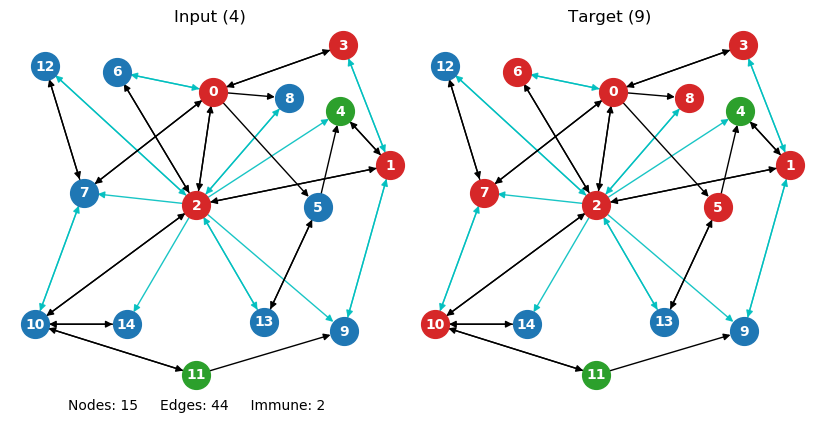

In [3]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

infected = (graph_in.node_features[:,0] == 1).nonzero().view(-1).tolist()
immune = (graph_in.node_features[:,1] == 1).nonzero().view(-1).tolist()
others = [i for i in range(graph_in.num_nodes) if i not in infected and i not in immune]

virtual = [list(graph_in.to_networkx().edges)[i] for i in (graph_in.edge_features[:,0] == 1).nonzero().view(-1).tolist()]
nonvirtual = [e for e in graph_in.to_networkx().edges if e not in virtual]

ax = axes[0]
node_ids = {i: str(i) for i in range(graph_in.num_nodes)}
nx.draw_networkx_nodes(graph_in.to_networkx(), nodelist=infected,   node_size=node_size, node_color='C3', pos=layout, ax=ax)
nx.draw_networkx_nodes(graph_in.to_networkx(), nodelist=immune,     node_size=node_size, node_color='C2', pos=layout, ax=ax)
nx.draw_networkx_nodes(graph_in.to_networkx(), nodelist=others,     node_size=node_size, node_color='C0', pos=layout, ax=ax)
nx.draw_networkx_edges(graph_in.to_networkx(), edgelist=virtual,    node_size=node_size, edge_color='c',  pos=layout, ax=ax, alpha=.9)
nx.draw_networkx_edges(graph_in.to_networkx(), edgelist=nonvirtual, node_size=node_size, edge_color='k',  pos=layout, ax=ax)
nx.draw_networkx_labels(graph_in.to_networkx(), pos=layout, labels=node_ids, ax=ax, font_size=font_size, font_weight='bold', font_color='white')
ax.set_title(f'Input ({((graph_in.node_features[:,0] == 1).int()).sum().item()})')
ax.tick_params(axis='both', which='both', bottom=False, labelbottom=False, left=False, labelleft=False)
ax.set_ylim(-.71, .66)
ax.set_xlim(-.8, .70)
ax.axis('off')
ax.text(-.1, -.78, 
        f'Nodes: {graph_in.num_nodes}     '
        f'Edges: {graph_in.num_edges}     '
        f'Immune: {((graph_in.node_features[:,1] == 1).int()).sum().item()}', fontsize=10, ha='center')

ax = axes[1]
infected_target = graph_target.node_features[:,0].nonzero().view(-1).tolist()
others_target = [i for i in range(graph_target.num_nodes) if i not in infected_target and i not in immune]
nx.draw_networkx_nodes(graph_in.to_networkx(), nodelist=infected_target, node_size=node_size, node_color='C3', pos=layout, ax=ax)
nx.draw_networkx_nodes(graph_in.to_networkx(), nodelist=immune,          node_size=node_size, node_color='C2', pos=layout, ax=ax)
nx.draw_networkx_nodes(graph_in.to_networkx(), nodelist=others_target,   node_size=node_size, node_color='C0', pos=layout, ax=ax)
nx.draw_networkx_edges(graph_in.to_networkx(), edgelist=virtual,    node_size=node_size, edge_color='c',  pos=layout, ax=ax, alpha=.9)
nx.draw_networkx_edges(graph_in.to_networkx(), edgelist=nonvirtual, node_size=node_size, edge_color='k',  pos=layout, ax=ax)
nx.draw_networkx_labels(graph_in.to_networkx(), pos=layout, labels=node_ids, ax=ax, font_size=font_size, font_weight='bold', font_color='white')
ax.set_title(f'Target ({graph_target.node_features[:,0].sum().int().item()})')
ax.tick_params(axis='both', which='both', bottom=False, labelbottom=False, left=False, labelleft=False)
ax.set_ylim(-.71, .66)
ax.set_xlim(-.8, .70)
ax.axis('off')

fig.tight_layout(pad=0)
fig.patch.set_facecolor('white')

display(fig)

### Import trained model

In [4]:
experiment = Path('../models/infection/lr.001_nodes.1_count1_wd.0001_MPUKHT')

with experiment.joinpath('experiment.latest.yaml').open('r') as f:
    model = munchify(yaml.safe_load(f)['model'])

if 'aggregation' not in model.kwargs:
        model.kwargs.aggregation='max'
if 'bias' not in model.kwargs:
    model.kwargs.bias=False     
model.state_dict = experiment / 'model.latest.pt'

net = InfectionGN(*model.args, **model.kwargs)
net.load_state_dict(torch.load(model.state_dict, map_location='cpu'))

### Make a prediction with the loaded model

In [5]:
graph_out = net(tg.GraphBatch.collate([graph_in]))[0]

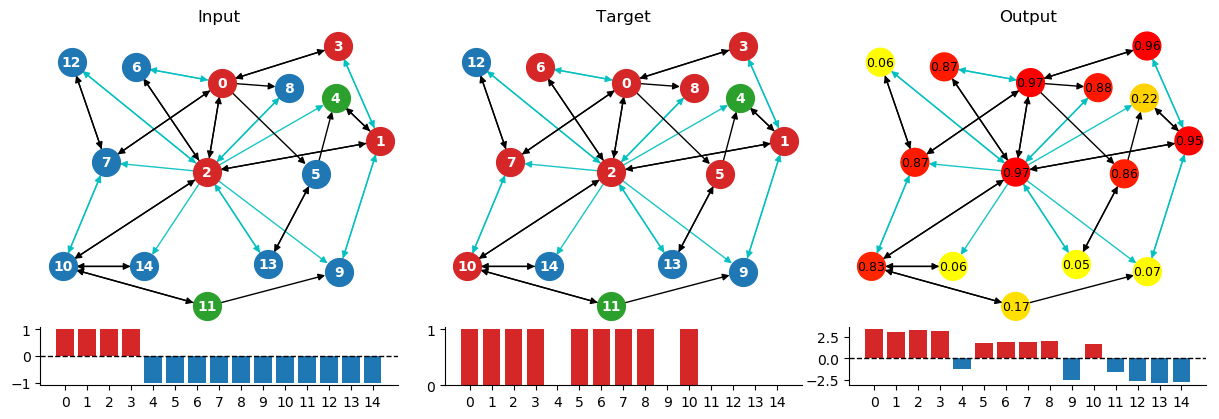

In [6]:
gs = gridspec.GridSpec(2, 3, height_ratios=[5, 1])
fig = plt.figure(figsize=(12, 4))

ax = fig.add_subplot(gs[0,0])
node_ids = {i: str(i) for i in range(graph_in.num_nodes)}
nx.draw_networkx_nodes(graph_in.to_networkx(), nodelist=infected, node_size=node_size, node_color='C3', pos=layout, ax=ax)
nx.draw_networkx_nodes(graph_in.to_networkx(), nodelist=immune,   node_size=node_size, node_color='C2', pos=layout, ax=ax)
nx.draw_networkx_nodes(graph_in.to_networkx(), nodelist=others,   node_size=node_size, node_color='C0', pos=layout, ax=ax)
nx.draw_networkx_edges(graph_in.to_networkx(), edgelist=virtual,    node_size=node_size, edge_color='c',  pos=layout, ax=ax, alpha=.9)
nx.draw_networkx_edges(graph_in.to_networkx(), edgelist=nonvirtual, node_size=node_size, edge_color='k',  pos=layout, ax=ax, )
nx.draw_networkx_labels(graph_in.to_networkx(), pos=layout, labels=node_ids, ax=ax, font_size=font_size, font_weight='bold', font_color='white')
ax.set_title('Input')
ax.tick_params(axis='both', which='both', bottom=False, labelbottom=False, left=False, labelleft=False)
ax.set_ylim(-.73, .68)
ax.set_xlim(-.8, .70)
ax.axis('off')

ax = fig.add_subplot(gs[0,1])
infected_target = graph_target.node_features[:,0].nonzero().view(-1).tolist()
others_target = [i for i in range(graph_target.num_nodes) if i not in infected_target and i not in immune]
nx.draw_networkx_nodes(graph_in.to_networkx(), nodelist=infected_target, node_size=node_size, node_color='C3', pos=layout, ax=ax)
nx.draw_networkx_nodes(graph_in.to_networkx(), nodelist=immune,   node_size=node_size, node_color='C2', pos=layout, ax=ax)
nx.draw_networkx_nodes(graph_in.to_networkx(), nodelist=others_target,   node_size=node_size, node_color='C0', pos=layout, ax=ax)
nx.draw_networkx_edges(graph_in.to_networkx(), edgelist=virtual,    node_size=node_size, edge_color='c',  pos=layout, ax=ax, alpha=.9)
nx.draw_networkx_edges(graph_in.to_networkx(), edgelist=nonvirtual, node_size=node_size, edge_color='k',  pos=layout, ax=ax)
nx.draw_networkx_labels(graph_in.to_networkx(), pos=layout, labels=node_ids, ax=ax, font_size=font_size, font_weight='bold', font_color='white')
ax.set_title(f'Target')# ({graph_target.global_features.item()})')
ax.tick_params(axis='both', which='both', bottom=False, labelbottom=False, left=False, labelleft=False)
ax.set_ylim(-.73, .68)
ax.set_xlim(-.8, .70)
ax.axis('off')

ax = fig.add_subplot(gs[0,2])
predicted_colors = graph_out.node_features.view(-1).sigmoid().tolist()
predicted_probs = {n: l for n, l in enumerate(graph_out.node_features.sigmoid().view(-1).detach().numpy().round(2).astype(str).tolist())}
nx.draw_networkx_nodes(graph_in.to_networkx(), node_size=node_size, node_color=predicted_colors, cmap='autumn_r', pos=layout, ax=ax)
nx.draw_networkx_edges(graph_in.to_networkx(), edgelist=virtual,    node_size=node_size, edge_color='c',  pos=layout, ax=ax, alpha=.9)
nx.draw_networkx_edges(graph_in.to_networkx(), edgelist=nonvirtual, node_size=node_size, edge_color='k',  pos=layout, ax=ax)
nx.draw_networkx_labels(graph_in.to_networkx(), pos=layout, labels=predicted_probs, ax=ax, font_size=font_size-1)
ax.set_title(f'Output')# ({graph_out.global_features.item():.2f})')
ax.tick_params(axis='both', which='both', bottom=False, labelbottom=False, left=False, labelleft=False)
ax.set_ylim(-.73, .68)
ax.set_xlim(-.8, .70)
ax.axis('off')

ax = fig.add_subplot(gs[1,0])
ax.bar(torch.arange(len(graph_in.node_features)), graph_in.node_features.detach()[:,0], color=['C3' if p>0 else 'C0' for p in graph_in.node_features.detach()[:,0]])
ax.set_xticks(torch.arange(len(graph_in.node_features)))
ax.axhline(0, color='k', linestyle='--', linewidth=1.)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax = fig.add_subplot(gs[1,1])
ax.bar(torch.arange(len(graph_target.node_features)), graph_target.node_features.detach().float()[:,0], color='C3')
ax.set_xticks(torch.arange(len(graph_in.node_features)))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax = fig.add_subplot(gs[1,2])
ax.bar(torch.arange(len(graph_out.node_features)), graph_out.node_features.detach()[:,0], color=['C3' if p>0 else 'C0' for p in graph_out.node_features.view(-1)])
ax.set_xticks(torch.arange(len(graph_in.node_features)))
ax.axhline(0, color='k', linestyle='--', linewidth=1.)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

fig.tight_layout(pad=0)
display(fig)
fig.savefig('biggraph-output.png', dpi=300, pad_inches=0)

## Sensitivity

### Import trained model

In [7]:
net = InfectionGN(*model.args, **model.kwargs)
net.load_state_dict(torch.load(model.state_dict, map_location='cpu'))

### SA: Explain node 10 that was healty and is now infected
- If node `2` was more sick, node `10` would be more infected
- If node `2` was more immune, node `10` would be less infected
- If edge `2->10` was less virtual, node `10` would be more infected

General message: sensitivity explains the variation of the output as a consequence of a variation of the input

In [8]:
batch = tg.GraphBatch.collate([graph_in]).requires_grad_()
graph_out = net(batch)[0]

N = 10
node_relevance = torch.zeros_like(graph_out.node_features)
node_relevance[N] = 1

batch.zero_grad_()
graph_out.node_features.backward(node_relevance)
title=f'Sensitivity analysis for node {N}'

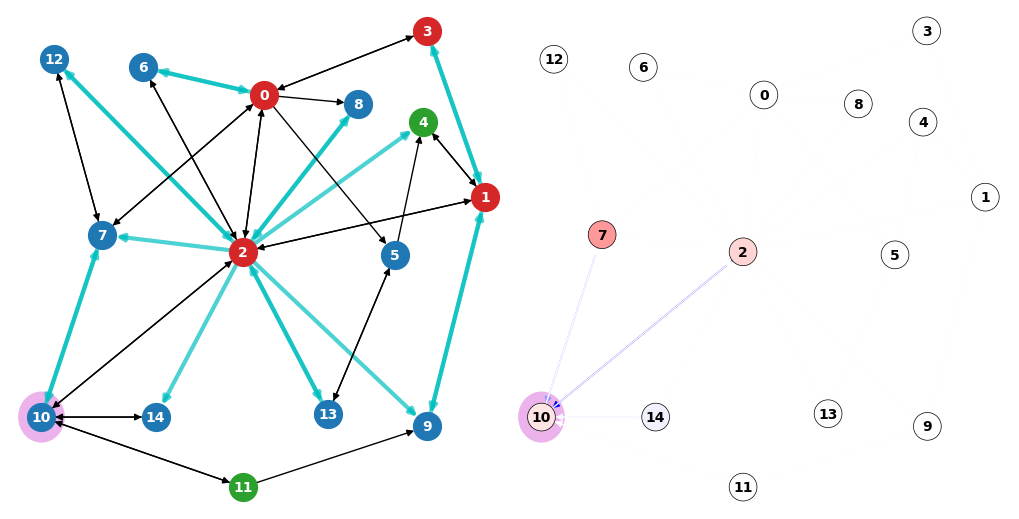

In [9]:
fig = plt.figure(figsize=(10, 5))

ax = plt.subplot2grid((1,2), loc=(0,0), fig=fig)
ax.add_patch(patches.Circle(layout[N], radius=.07, color='m', fill=True, alpha=.3, linewidth=0))
node_ids = {i: str(i) for i in range(graph_in.num_nodes)}
nx.draw_networkx_nodes(graph_in.to_networkx(), nodelist=infected, node_size=node_size, node_color='C3', pos=layout, ax=ax)
nx.draw_networkx_nodes(graph_in.to_networkx(), nodelist=immune,   node_size=node_size, node_color='C2', pos=layout, ax=ax)
nx.draw_networkx_nodes(graph_in.to_networkx(), nodelist=others,   node_size=node_size, node_color='C0', pos=layout, ax=ax)
nx.draw_networkx_edges(graph_in.to_networkx(), edgelist=virtual,    node_size=node_size, edge_color='c',  pos=layout, ax=ax, width=3., alpha=.7)
nx.draw_networkx_edges(graph_in.to_networkx(), edgelist=nonvirtual, node_size=node_size, edge_color='k',  pos=layout, ax=ax)
nx.draw_networkx_labels(graph_in.to_networkx(), pos=layout, labels=node_ids, ax=ax, font_size=font_size, font_weight='bold', font_color='white')
ax.tick_params(axis='both', which='both', bottom=False, labelbottom=False, left=False, labelleft=False)
ax.tick_params(axis='both', which='both', bottom=False, labelbottom=False, left=False, labelleft=False)
ax.set_ylim(-.71, .66)
ax.set_xlim(-.8, .70)
ax.axis('off')

ax = plt.subplot2grid((1,2), loc=(0,1), fig=fig)
ax.add_patch(patches.Circle(layout[N], radius=.07, color='m', fill=True, alpha=.3, linewidth=0))
vmax=max(batch.node_features.grad.sum(dim=1).abs().max(),batch.edge_features.grad.sum(dim=1).abs().max(),1e-16)
nx.draw_networkx_nodes(graph_in.to_networkx(), node_size=node_size, node_color=batch.node_features.grad.sum(dim=1), cmap='bwr',vmin=-vmax, vmax=vmax, pos=layout, ax=ax, linewidths=.5, edgecolors='k')
nx.draw_networkx_edges(graph_in.to_networkx(), node_size=node_size, edge_color=batch.edge_features.grad.sum(dim=1), edge_cmap=cm.get_cmap('bwr'),edge_vmin=-vmax, edge_vmax=vmax, pos=layout, ax=ax)
nx.draw_networkx_labels(graph_in.to_networkx(), pos=layout, labels=node_ids, ax=ax, font_size=font_size, font_weight='bold', font_color='k')
ax.tick_params(axis='both', which='both', bottom=False, labelbottom=False, left=False, labelleft=False)
ax.set_ylim(-.71, .66)
ax.set_xlim(-.8, .70)
ax.axis('off')

fig.tight_layout(pad=0)
display(fig)
fig.savefig(f'biggraph-node-{N}-sa.png', dpi=300, pad_inches=0)
plt.close(fig)

/anaconda3/envs/gn-exp/lib/python3.7/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


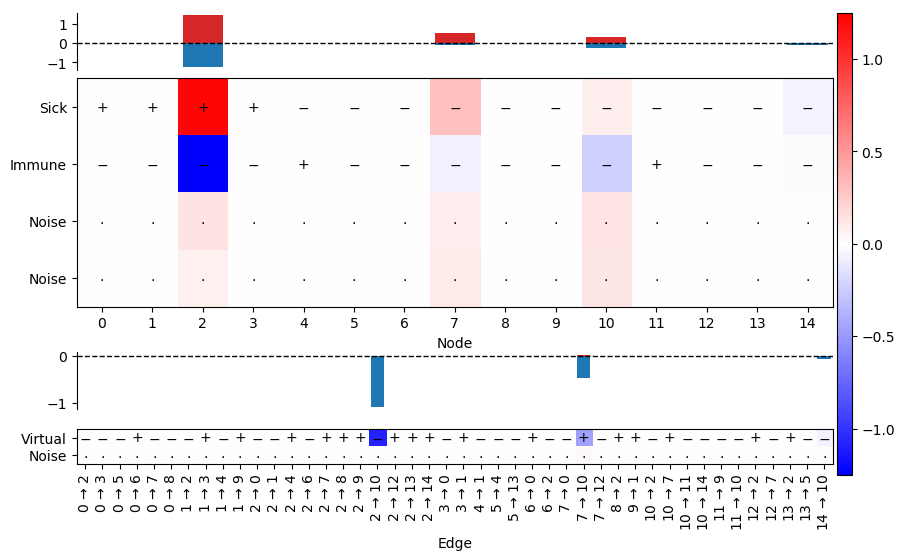

In [10]:
fig = plt.figure(figsize=(10, 6))
grid = plt.GridSpec(5, 2, height_ratios=[1, 4, .5, 1, 1], width_ratios=[50, 1], hspace=.1, wspace=.01)

vmax=max(
    batch.node_features.grad.abs().max(),
    batch.edge_features.grad.abs().max(),
    1e-16
)

ax = fig.add_subplot(grid[0,0])
ax.bar(torch.arange(graph_in.num_nodes), batch.node_features.grad.clamp(min=0).sum(dim=1), color='C3')
ax.bar(torch.arange(graph_in.num_nodes), batch.node_features.grad.clamp(max=0).sum(dim=1), color='C0')
ax.set_xticks([])
ax.tick_params(axis='both', which='both', bottom=False, labelbottom=False)
ax.axhline(0, color='k', linestyle='--', linewidth=1.)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)

ax = fig.add_subplot(grid[1,0], sharex=ax)
im = ax.imshow(batch.node_features.grad.t(), cmap='bwr', vmin=-vmax, vmax=vmax, aspect='auto')
ax.set_xticks(torch.arange(graph_in.num_nodes))
ax.set_xlim(-.5, graph_in.num_nodes -.5)
ax.set_yticks(torch.arange(4))
ax.set_ylim(4 -.5, -.5)
ax.set_yticklabels(['Sick', 'Immune', 'Noise', 'Noise'])
ax.set_xlabel('Node')
for (j,i),label in np.ndenumerate(batch.node_features.detach().t().numpy()):
    ax.text(i,j, label_txt(label),ha='center',va='center')

ax = fig.add_subplot(grid[3,0])
ax.bar(torch.arange(graph_in.num_edges), batch.edge_features.grad.clamp(min=0).sum(dim=1), color='C3')
ax.bar(torch.arange(graph_in.num_edges), batch.edge_features.grad.clamp(max=0).sum(dim=1), color='C0')
ax.set_xticks([])
ax.tick_params(axis='both', which='both', bottom=False, labelbottom=False)
ax.axhline(0, color='k', linestyle='--', linewidth=1.)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)

ax = fig.add_subplot(grid[4, 0], sharex=ax)
im = ax.imshow(batch.edge_features.grad.t(), cmap='bwr', vmin=-vmax, vmax=vmax)
ax.set_xticks(torch.arange(graph_in.num_edges))
ax.set_xlim(-.5, graph_in.num_edges -.5)
ax.set_xticklabels([f'${s}\\ \\to\\ {r}$' for s, r in zip(graph_in.senders, graph_in.receivers)], rotation=90)
ax.set_yticks(torch.arange(2))
ax.set_ylim(2 -.5, -.5)
ax.set_yticklabels(['Virtual', 'Noise'])
ax.set_xlabel('Edge');
for (j,i),label in np.ndenumerate(batch.edge_features.t().detach().numpy()):
    ax.text(i,j, label_txt(label),ha='center',va='center')

ax = fig.add_subplot(grid[:, 1])
fig.colorbar(mappable=im, cax=ax);

fig.tight_layout(pad=0)
display(fig)
fig.savefig(f'biggraph-node-{N}-sa-nodesedges.png', dpi=300, pad_inches=0)
plt.close(fig)

### SA: Explain node 13 that was healty and still is

In [11]:
batch = tg.GraphBatch.collate([graph_in]).requires_grad_()
graph_out = net(batch)[0]

N = 13
node_relevance = torch.zeros_like(graph_out.node_features)
node_relevance[N] = 1

batch.zero_grad_()
graph_out.node_features.backward(node_relevance)
title=f'Sensitivity analysis for node {N}'

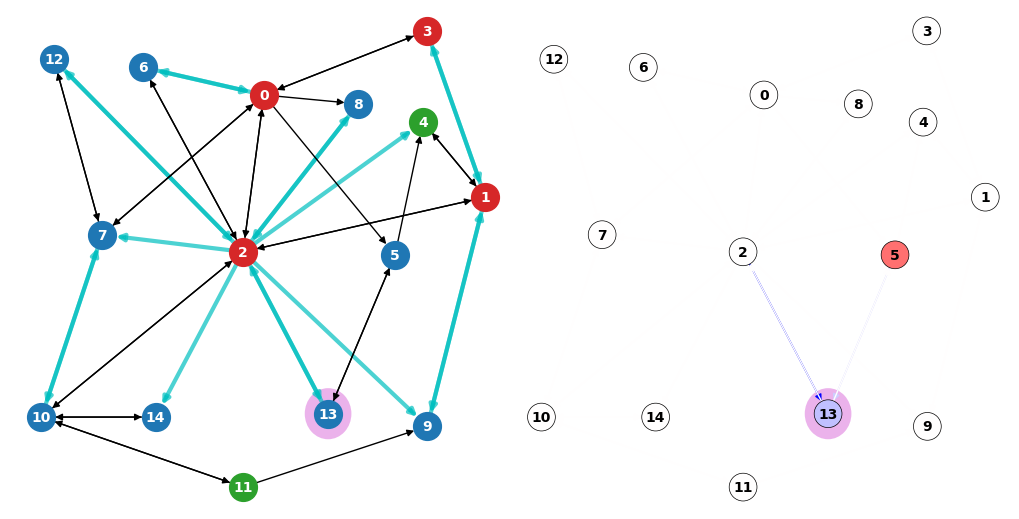

In [12]:
fig = plt.figure(figsize=(10, 5))

ax = plt.subplot2grid((1,2), loc=(0,0), fig=fig)
ax.add_patch(patches.Circle(layout[N], radius=.07, color='m', fill=True, alpha=.3, linewidth=0))
node_ids = {i: str(i) for i in range(graph_in.num_nodes)}
nx.draw_networkx_nodes(graph_in.to_networkx(), nodelist=infected, node_size=node_size, node_color='C3', pos=layout, ax=ax)
nx.draw_networkx_nodes(graph_in.to_networkx(), nodelist=immune,   node_size=node_size, node_color='C2', pos=layout, ax=ax)
nx.draw_networkx_nodes(graph_in.to_networkx(), nodelist=others,   node_size=node_size, node_color='C0', pos=layout, ax=ax)
nx.draw_networkx_edges(graph_in.to_networkx(), edgelist=virtual,    node_size=node_size, edge_color='c',  pos=layout, ax=ax, width=3., alpha=.7)
nx.draw_networkx_edges(graph_in.to_networkx(), edgelist=nonvirtual, node_size=node_size, edge_color='k',  pos=layout, ax=ax)
nx.draw_networkx_labels(graph_in.to_networkx(), pos=layout, labels=node_ids, ax=ax, font_size=font_size, font_weight='bold', font_color='white')
ax.tick_params(axis='both', which='both', bottom=False, labelbottom=False, left=False, labelleft=False)
ax.tick_params(axis='both', which='both', bottom=False, labelbottom=False, left=False, labelleft=False)
ax.set_ylim(-.71, .66)
ax.set_xlim(-.8, .70)
ax.axis('off')

ax = plt.subplot2grid((1,2), loc=(0,1), fig=fig)
ax.add_patch(patches.Circle(layout[N], radius=.07, color='m', fill=True, alpha=.3, linewidth=0))
vmax=max(batch.node_features.grad.sum(dim=1).abs().max(),batch.edge_features.grad.sum(dim=1).abs().max(),1e-16)
nx.draw_networkx_nodes(graph_in.to_networkx(), node_size=node_size, node_color=batch.node_features.grad.sum(dim=1), cmap='bwr',vmin=-vmax, vmax=vmax, pos=layout, ax=ax, linewidths=.5, edgecolors='k')
nx.draw_networkx_edges(graph_in.to_networkx(), node_size=node_size, edge_color=batch.edge_features.grad.sum(dim=1), edge_cmap=cm.get_cmap('bwr'),edge_vmin=-vmax, edge_vmax=vmax, pos=layout, ax=ax)
nx.draw_networkx_labels(graph_in.to_networkx(), pos=layout, labels=node_ids, ax=ax, font_size=font_size, font_weight='bold', font_color='k')
ax.tick_params(axis='both', which='both', bottom=False, labelbottom=False, left=False, labelleft=False)
ax.set_ylim(-.71, .66)
ax.set_xlim(-.8, .70)
ax.axis('off')

fig.tight_layout(pad=0)
display(fig)
fig.savefig(f'biggraph-node-{N}-sa.png', dpi=300, pad_inches=0)
plt.close(fig)

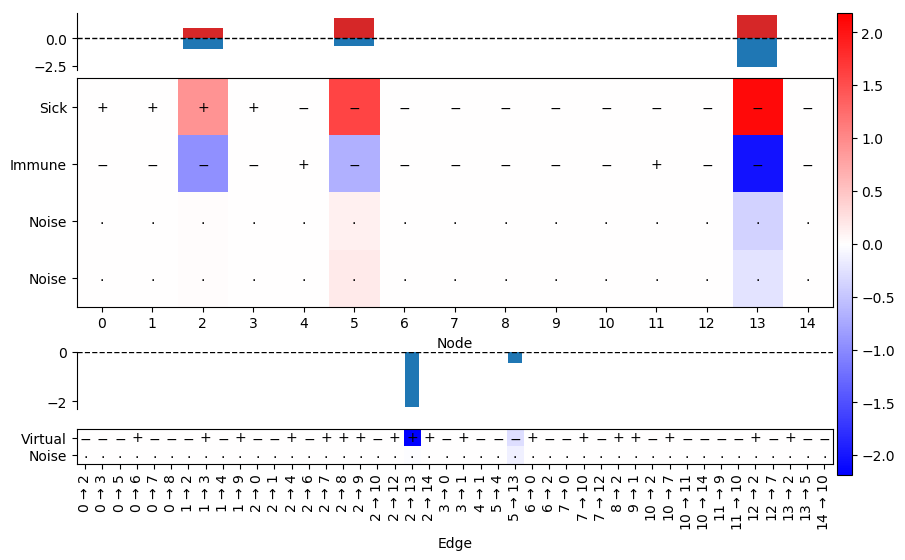

In [13]:
fig = plt.figure(figsize=(10, 6))
grid = plt.GridSpec(5, 2, height_ratios=[1, 4, .5, 1, 1], width_ratios=[50, 1], hspace=.1, wspace=.01)

vmax=max(
    batch.node_features.grad.abs().max(),
    batch.edge_features.grad.abs().max(),
    1e-16
)

ax = fig.add_subplot(grid[0,0])
ax.bar(torch.arange(graph_in.num_nodes), batch.node_features.grad.clamp(min=0).sum(dim=1), color='C3')
ax.bar(torch.arange(graph_in.num_nodes), batch.node_features.grad.clamp(max=0).sum(dim=1), color='C0')
ax.set_xticks([])
ax.tick_params(axis='both', which='both', bottom=False, labelbottom=False)
ax.axhline(0, color='k', linestyle='--', linewidth=1.)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)

ax = fig.add_subplot(grid[1,0], sharex=ax)
im = ax.imshow(batch.node_features.grad.t(), cmap='bwr', vmin=-vmax, vmax=vmax, aspect='auto')
ax.set_xticks(torch.arange(graph_in.num_nodes))
ax.set_xlim(-.5, graph_in.num_nodes -.5)
ax.set_yticks(torch.arange(4))
ax.set_ylim(4 -.5, -.5)
ax.set_yticklabels(['Sick', 'Immune', 'Noise', 'Noise'])
ax.set_xlabel('Node')
for (j,i),label in np.ndenumerate(batch.node_features.detach().t().numpy()):
    ax.text(i,j, label_txt(label),ha='center',va='center')

ax = fig.add_subplot(grid[3,0])
ax.bar(torch.arange(graph_in.num_edges), batch.edge_features.grad.clamp(min=0).sum(dim=1), color='C3')
ax.bar(torch.arange(graph_in.num_edges), batch.edge_features.grad.clamp(max=0).sum(dim=1), color='C0')
ax.set_xticks([])
ax.tick_params(axis='both', which='both', bottom=False, labelbottom=False)
ax.axhline(0, color='k', linestyle='--', linewidth=1.)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)

ax = fig.add_subplot(grid[4, 0], sharex=ax)
im = ax.imshow(batch.edge_features.grad.t(), cmap='bwr', vmin=-vmax, vmax=vmax)
ax.set_xticks(torch.arange(graph_in.num_edges))
ax.set_xlim(-.5, graph_in.num_edges -.5)
ax.set_xticklabels([f'${s}\\ \\to\\ {r}$' for s, r in zip(graph_in.senders, graph_in.receivers)], rotation=90)
ax.set_yticks(torch.arange(2))
ax.set_ylim(2 -.5, -.5)
ax.set_yticklabels(['Virtual', 'Noise'])
ax.set_xlabel('Edge');
for (j,i),label in np.ndenumerate(batch.edge_features.t().detach().numpy()):
    ax.text(i,j, label_txt(label),ha='center',va='center')

ax = fig.add_subplot(grid[:, 1])
fig.colorbar(mappable=im, cax=ax);

fig.tight_layout(pad=0)
display(fig)
fig.savefig(f'biggraph-node-{N}-sa-nodesedges.png', dpi=300, pad_inches=0)
plt.close(fig)

### SA: Explain node 4 that was immune

- Most of the negative gradient is placed on the immune feture of node 4 itself, i.e. if it was more immune it would be more immune
- If edge `1->4` was less virtual the prediction for sick would increase

In [14]:
batch = tg.GraphBatch.collate([graph_in]).requires_grad_()
graph_out = net(batch)[0]

N = 4
node_relevance = torch.zeros_like(graph_out.node_features)
node_relevance[N] = 1

batch.zero_grad_()
graph_out.node_features.backward(node_relevance)
title=f'Sensitivity analysis for node {N}'

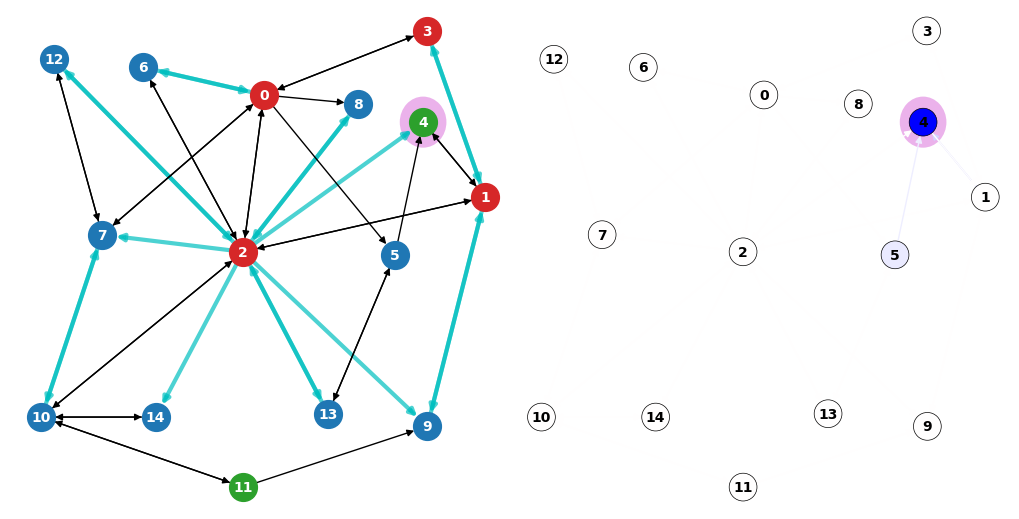

In [15]:
fig = plt.figure(figsize=(10, 5))

ax = plt.subplot2grid((1,2), loc=(0,0), fig=fig)
ax.add_patch(patches.Circle(layout[N], radius=.07, color='m', fill=True, alpha=.3, linewidth=0))
node_ids = {i: str(i) for i in range(graph_in.num_nodes)}
nx.draw_networkx_nodes(graph_in.to_networkx(), nodelist=infected, node_size=node_size, node_color='C3', pos=layout, ax=ax)
nx.draw_networkx_nodes(graph_in.to_networkx(), nodelist=immune,   node_size=node_size, node_color='C2', pos=layout, ax=ax)
nx.draw_networkx_nodes(graph_in.to_networkx(), nodelist=others,   node_size=node_size, node_color='C0', pos=layout, ax=ax)
nx.draw_networkx_edges(graph_in.to_networkx(), edgelist=virtual,    node_size=node_size, edge_color='c',  pos=layout, ax=ax, width=3., alpha=.7)
nx.draw_networkx_edges(graph_in.to_networkx(), edgelist=nonvirtual, node_size=node_size, edge_color='k',  pos=layout, ax=ax)
nx.draw_networkx_labels(graph_in.to_networkx(), pos=layout, labels=node_ids, ax=ax, font_size=font_size, font_weight='bold', font_color='white')
ax.tick_params(axis='both', which='both', bottom=False, labelbottom=False, left=False, labelleft=False)
ax.tick_params(axis='both', which='both', bottom=False, labelbottom=False, left=False, labelleft=False)
ax.set_ylim(-.71, .66)
ax.set_xlim(-.8, .70)
ax.axis('off')

ax = plt.subplot2grid((1,2), loc=(0,1), fig=fig)
ax.add_patch(patches.Circle(layout[N], radius=.07, color='m', fill=True, alpha=.3, linewidth=0))
vmax=max(batch.node_features.grad.sum(dim=1).abs().max(),batch.edge_features.grad.sum(dim=1).abs().max(),1e-16)
nx.draw_networkx_nodes(graph_in.to_networkx(), node_size=node_size, node_color=batch.node_features.grad.sum(dim=1), cmap='bwr',vmin=-vmax, vmax=vmax, pos=layout, ax=ax, linewidths=.5, edgecolors='k')
nx.draw_networkx_edges(graph_in.to_networkx(), node_size=node_size, edge_color=batch.edge_features.grad.sum(dim=1), edge_cmap=cm.get_cmap('bwr'),edge_vmin=-vmax, edge_vmax=vmax, pos=layout, ax=ax)
nx.draw_networkx_labels(graph_in.to_networkx(), pos=layout, labels=node_ids, ax=ax, font_size=font_size, font_weight='bold', font_color='k')
ax.tick_params(axis='both', which='both', bottom=False, labelbottom=False, left=False, labelleft=False)
ax.set_ylim(-.71, .66)
ax.set_xlim(-.8, .70)
ax.axis('off')

fig.tight_layout(pad=0)
display(fig)
fig.savefig(f'biggraph-node-{N}-sa.png', dpi=300, pad_inches=0)
plt.close(fig)

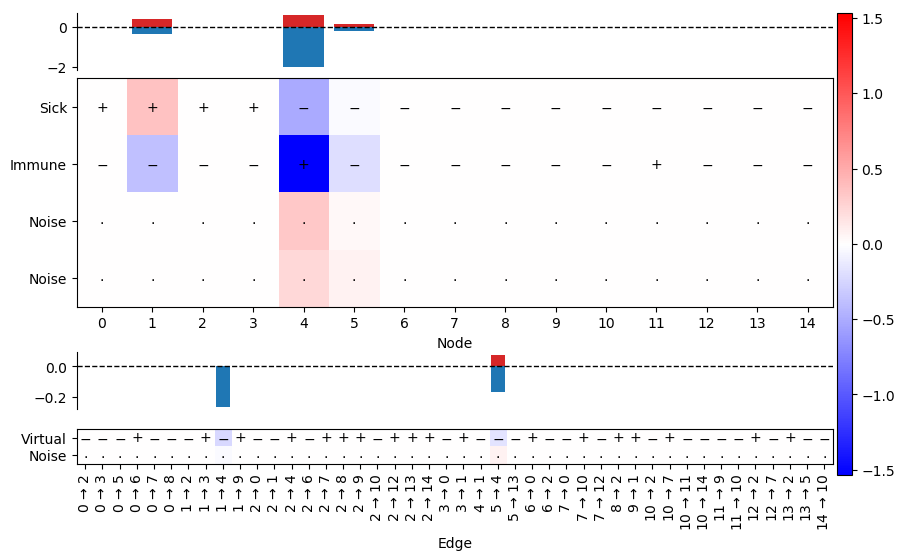

In [16]:
fig = plt.figure(figsize=(10, 6))
grid = plt.GridSpec(5, 2, height_ratios=[1, 4, .5, 1, 1], width_ratios=[50, 1], hspace=.1, wspace=.01)

vmax=max(
    batch.node_features.grad.abs().max(),
    batch.edge_features.grad.abs().max(),
    1e-16
)

ax = fig.add_subplot(grid[0,0])
ax.bar(torch.arange(graph_in.num_nodes), batch.node_features.grad.clamp(min=0).sum(dim=1), color='C3')
ax.bar(torch.arange(graph_in.num_nodes), batch.node_features.grad.clamp(max=0).sum(dim=1), color='C0')
ax.set_xticks([])
ax.tick_params(axis='both', which='both', bottom=False, labelbottom=False)
ax.axhline(0, color='k', linestyle='--', linewidth=1.)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)

ax = fig.add_subplot(grid[1,0], sharex=ax)
im = ax.imshow(batch.node_features.grad.t(), cmap='bwr', vmin=-vmax, vmax=vmax, aspect='auto')
ax.set_xticks(torch.arange(graph_in.num_nodes))
ax.set_xlim(-.5, graph_in.num_nodes -.5)
ax.set_yticks(torch.arange(4))
ax.set_ylim(4 -.5, -.5)
ax.set_yticklabels(['Sick', 'Immune', 'Noise', 'Noise'])
ax.set_xlabel('Node')
for (j,i),label in np.ndenumerate(batch.node_features.detach().t().numpy()):
    ax.text(i,j, label_txt(label),ha='center',va='center')

ax = fig.add_subplot(grid[3,0])
ax.bar(torch.arange(graph_in.num_edges), batch.edge_features.grad.clamp(min=0).sum(dim=1), color='C3')
ax.bar(torch.arange(graph_in.num_edges), batch.edge_features.grad.clamp(max=0).sum(dim=1), color='C0')
ax.set_xticks([])
ax.tick_params(axis='both', which='both', bottom=False, labelbottom=False)
ax.axhline(0, color='k', linestyle='--', linewidth=1.)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)

ax = fig.add_subplot(grid[4, 0], sharex=ax)
im = ax.imshow(batch.edge_features.grad.t(), cmap='bwr', vmin=-vmax, vmax=vmax)
ax.set_xticks(torch.arange(graph_in.num_edges))
ax.set_xlim(-.5, graph_in.num_edges -.5)
ax.set_xticklabels([f'${s}\\ \\to\\ {r}$' for s, r in zip(graph_in.senders, graph_in.receivers)], rotation=90)
ax.set_yticks(torch.arange(2))
ax.set_ylim(2 -.5, -.5)
ax.set_yticklabels(['Virtual', 'Noise'])
ax.set_xlabel('Edge');
for (j,i),label in np.ndenumerate(batch.edge_features.t().detach().numpy()):
    ax.text(i,j, label_txt(label),ha='center',va='center')

ax = fig.add_subplot(grid[:, 1])
fig.colorbar(mappable=im, cax=ax);

fig.tight_layout(pad=0)
display(fig)
fig.savefig(f'biggraph-node-{N}-sa-nodesedges.png', dpi=300, pad_inches=0)
plt.close(fig)

## Guided Backpropagation

In [17]:
class InfectionGNGuidedBP(InfectionGN):
    def __init__(self, aggregation, bias):
        super(InfectionGN, self).__init__()
        self.encoder = torch.nn.Sequential(OrderedDict({
            'edge': guidedbp.EdgeLinearGuidedBP(4, edge_features=2, bias=bias),
            'edge_relu': guidedbp.EdgeReLUGuidedBP(),
            'node': guidedbp.NodeLinearGuidedBP(8, node_features=4, bias=bias),
            'node_relu': guidedbp.NodeReLUGuidedBP(),
        }))
        self.hidden = torch.nn.Sequential(OrderedDict({
            'edge': guidedbp.EdgeLinearGuidedBP(8, edge_features=4, sender_features=8, bias=bias),
            'edge_relu': guidedbp.EdgeReLUGuidedBP(),
            'node': guidedbp.NodeLinearGuidedBP(8, node_features=8, incoming_features=8, aggregation=aggregation, bias=bias),
            'node_relu': guidedbp.NodeReLUGuidedBP()
        }))
        self.readout_nodes = guidedbp.NodeLinearGuidedBP(1, node_features=8, bias=True)
        self.readout_globals = guidedbp.GlobalLinearGuidedBP(1, node_features=8, aggregation='sum', bias=bias)

net = InfectionGNGuidedBP(*model.args, **model.kwargs)
net.load_state_dict(torch.load(model.state_dict, map_location='cpu'))

### GBP: Explain node 10 that was healty and is now infected
- Most of the explanation comes from node `2`, which is the cause for `10` getting infected
- However, the relevance on the edges `2->10` and `4->10` is placed on the uninformative feature, probably because the negative gradients are clipped and the small positive gradients stand out

In [18]:
batch = tg.GraphBatch.collate([graph_in]).requires_grad_()
batch.node_features.register_hook(lambda grad: grad.clamp(min=0))
batch.edge_features.register_hook(lambda grad: grad.clamp(min=0))
graph_out = net(batch)[0]

N = 10
node_relevance = torch.zeros_like(graph_out.node_features)
node_relevance[N] = 1

batch.zero_grad_()
graph_out.node_features.backward(node_relevance)
title=f'Guided backpropagation for node {N}'

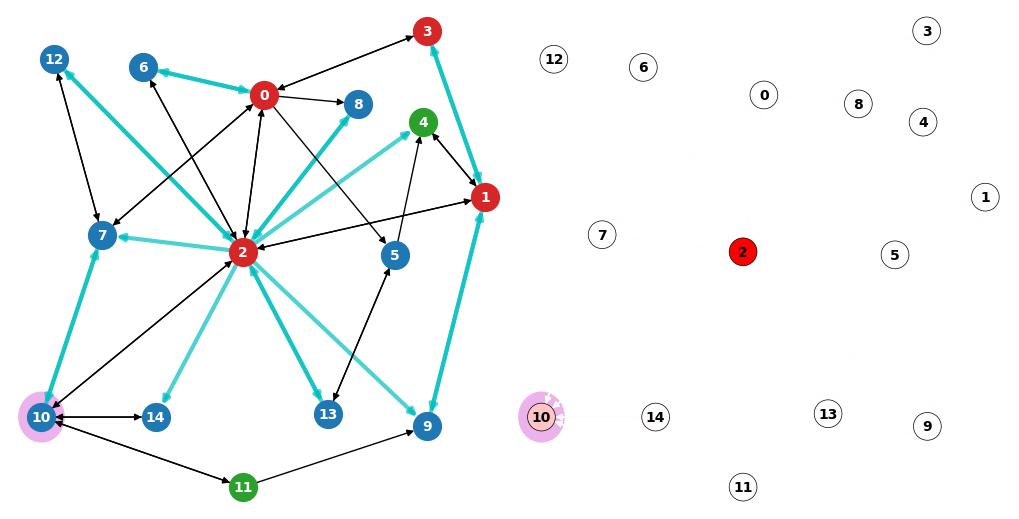

In [19]:
fig = plt.figure(figsize=(10, 5))

ax = plt.subplot2grid((1,2), loc=(0,0), fig=fig)
ax.add_patch(patches.Circle(layout[N], radius=.07, color='m', fill=True, alpha=.3, linewidth=0))
node_ids = {i: str(i) for i in range(graph_in.num_nodes)}
nx.draw_networkx_nodes(graph_in.to_networkx(), nodelist=infected, node_size=node_size, node_color='C3', pos=layout, ax=ax)
nx.draw_networkx_nodes(graph_in.to_networkx(), nodelist=immune,   node_size=node_size, node_color='C2', pos=layout, ax=ax)
nx.draw_networkx_nodes(graph_in.to_networkx(), nodelist=others,   node_size=node_size, node_color='C0', pos=layout, ax=ax)
nx.draw_networkx_edges(graph_in.to_networkx(), edgelist=virtual,    node_size=node_size, edge_color='c',  pos=layout, ax=ax, width=3., alpha=.7)
nx.draw_networkx_edges(graph_in.to_networkx(), edgelist=nonvirtual, node_size=node_size, edge_color='k',  pos=layout, ax=ax)
nx.draw_networkx_labels(graph_in.to_networkx(), pos=layout, labels=node_ids, ax=ax, font_size=font_size, font_weight='bold', font_color='white')
ax.tick_params(axis='both', which='both', bottom=False, labelbottom=False, left=False, labelleft=False)
ax.tick_params(axis='both', which='both', bottom=False, labelbottom=False, left=False, labelleft=False)
ax.set_ylim(-.71, .66)
ax.set_xlim(-.8, .70)
ax.axis('off')

ax = plt.subplot2grid((1,2), loc=(0,1), fig=fig)
ax.add_patch(patches.Circle(layout[N], radius=.07, color='m', fill=True, alpha=.3, linewidth=0))
vmax=max(batch.node_features.grad.sum(dim=1).abs().max(),batch.edge_features.grad.sum(dim=1).abs().max(),1e-16)
nx.draw_networkx_nodes(graph_in.to_networkx(), node_size=node_size, node_color=batch.node_features.grad.sum(dim=1), cmap='bwr',vmin=-vmax, vmax=vmax, pos=layout, ax=ax, linewidths=.5, edgecolors='k')
nx.draw_networkx_edges(graph_in.to_networkx(), node_size=node_size, edge_color=batch.edge_features.grad.sum(dim=1), edge_cmap=cm.get_cmap('bwr'),edge_vmin=-vmax, edge_vmax=vmax, pos=layout, ax=ax)
nx.draw_networkx_labels(graph_in.to_networkx(), pos=layout, labels=node_ids, ax=ax, font_size=font_size, font_weight='bold', font_color='k')
ax.tick_params(axis='both', which='both', bottom=False, labelbottom=False, left=False, labelleft=False)
ax.set_ylim(-.71, .66)
ax.set_xlim(-.8, .70)
ax.axis('off')

fig.tight_layout(pad=0)
display(fig)
fig.savefig(f'biggraph-node-{N}-gbp.png', dpi=300, pad_inches=0)
plt.close(fig)

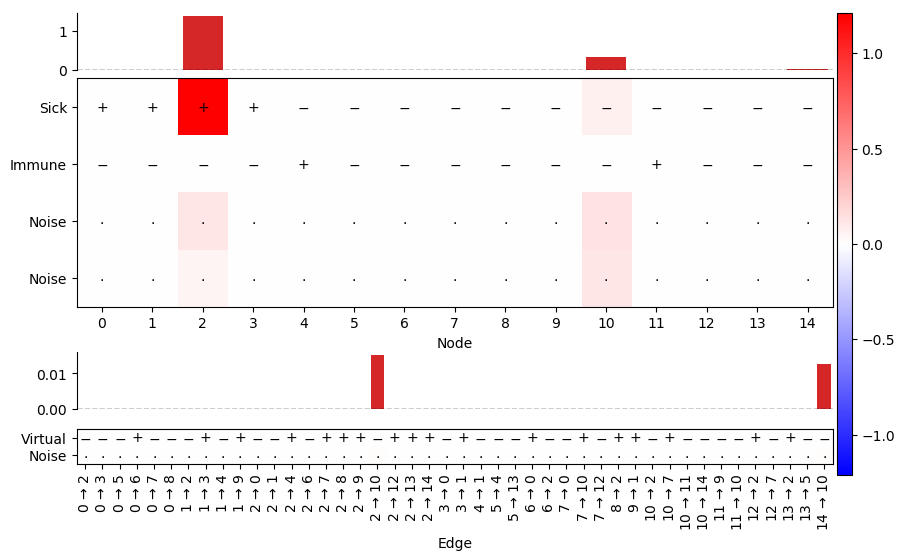

In [20]:
fig = plt.figure(figsize=(10, 6))
grid = plt.GridSpec(5, 2, height_ratios=[1, 4, .5, 1, 1], width_ratios=[50, 1], hspace=.1, wspace=.01)

vmax=max(
    batch.node_features.grad.abs().max(),
    batch.edge_features.grad.abs().max(),
    1e-16
)

ax = fig.add_subplot(grid[0,0])
ax.bar(torch.arange(graph_in.num_nodes), batch.node_features.grad.clamp(min=0).sum(dim=1), color='C3')
ax.set_xticks([])
ax.tick_params(axis='both', which='both', bottom=False, labelbottom=False)
ax.axhline(0, color='k', linestyle='--', linewidth=1.)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)

ax = fig.add_subplot(grid[1,0], sharex=ax)
im = ax.imshow(batch.node_features.grad.t(), cmap='bwr', vmin=-vmax, vmax=vmax, aspect='auto')
ax.set_xticks(torch.arange(graph_in.num_nodes))
ax.set_xlim(-.5, graph_in.num_nodes -.5)
ax.set_yticks(torch.arange(4))
ax.set_ylim(4 -.5, -.5)
ax.set_yticklabels(['Sick', 'Immune', 'Noise', 'Noise'])
ax.set_xlabel('Node')
for (j,i),label in np.ndenumerate(batch.node_features.detach().t().numpy()):
    ax.text(i,j, label_txt(label),ha='center',va='center')

ax = fig.add_subplot(grid[3,0])
ax.bar(torch.arange(graph_in.num_edges), batch.edge_features.grad.clamp(min=0).sum(dim=1), color='C3')
ax.set_xticks([])
ax.tick_params(axis='both', which='both', bottom=False, labelbottom=False)
ax.axhline(0, color='k', linestyle='--', linewidth=1.)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)

ax = fig.add_subplot(grid[4, 0], sharex=ax)
im = ax.imshow(batch.edge_features.grad.t(), cmap='bwr', vmin=-vmax, vmax=vmax)
ax.set_xticks(torch.arange(graph_in.num_edges))
ax.set_xlim(-.5, graph_in.num_edges -.5)
ax.set_xticklabels([f'${s}\\ \\to\\ {r}$' for s, r in zip(graph_in.senders, graph_in.receivers)], rotation=90)
ax.set_yticks(torch.arange(2))
ax.set_ylim(2 -.5, -.5)
ax.set_yticklabels(['Virtual', 'Noise'])
ax.set_xlabel('Edge');
for (j,i),label in np.ndenumerate(batch.edge_features.t().detach().numpy()):
    ax.text(i,j, label_txt(label),ha='center',va='center')

ax = fig.add_subplot(grid[:, 1])
fig.colorbar(mappable=im, cax=ax);

fig.tight_layout(pad=0)
display(fig)
fig.savefig(f'biggraph-node-{N}-gbp-nodesedges.png', dpi=300, pad_inches=0)
plt.close(fig)

### GBP: Explain node 13 that was healty and still is

In [21]:
batch = tg.GraphBatch.collate([graph_in]).requires_grad_()
batch.node_features.register_hook(lambda grad: grad.clamp(min=0))
batch.edge_features.register_hook(lambda grad: grad.clamp(min=0))
graph_out = net(batch)[0]

N = 13
node_relevance = torch.zeros_like(graph_out.node_features)
node_relevance[N] = 1

batch.zero_grad_()
graph_out.node_features.backward(node_relevance)
title=f'Guided backpropagation for node {N}'

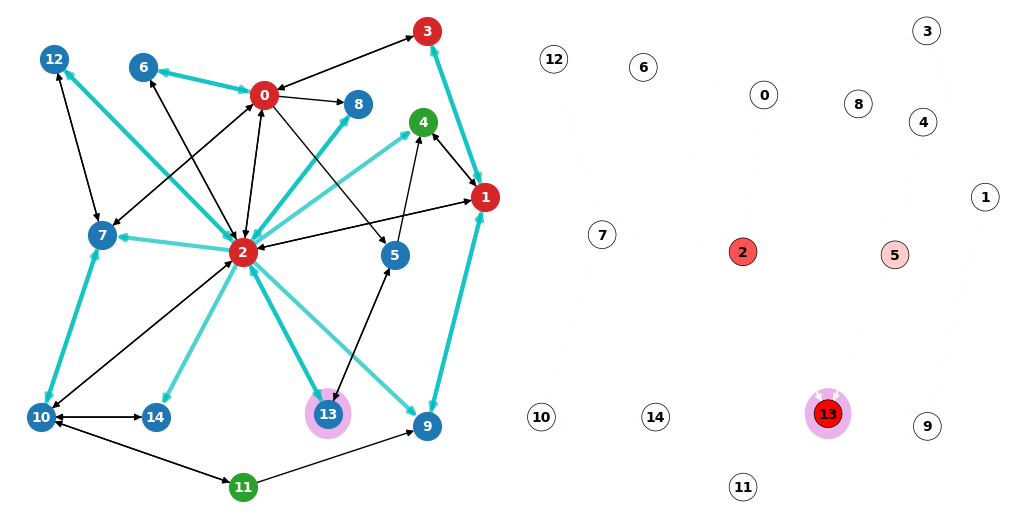

In [22]:
fig = plt.figure(figsize=(10, 5))

ax = plt.subplot2grid((1,2), loc=(0,0), fig=fig)
ax.add_patch(patches.Circle(layout[N], radius=.07, color='m', fill=True, alpha=.3, linewidth=0))
node_ids = {i: str(i) for i in range(graph_in.num_nodes)}
nx.draw_networkx_nodes(graph_in.to_networkx(), nodelist=infected, node_size=node_size, node_color='C3', pos=layout, ax=ax)
nx.draw_networkx_nodes(graph_in.to_networkx(), nodelist=immune,   node_size=node_size, node_color='C2', pos=layout, ax=ax)
nx.draw_networkx_nodes(graph_in.to_networkx(), nodelist=others,   node_size=node_size, node_color='C0', pos=layout, ax=ax)
nx.draw_networkx_edges(graph_in.to_networkx(), edgelist=virtual,    node_size=node_size, edge_color='c',  pos=layout, ax=ax, width=3., alpha=.7)
nx.draw_networkx_edges(graph_in.to_networkx(), edgelist=nonvirtual, node_size=node_size, edge_color='k',  pos=layout, ax=ax)
nx.draw_networkx_labels(graph_in.to_networkx(), pos=layout, labels=node_ids, ax=ax, font_size=font_size, font_weight='bold', font_color='white')
ax.tick_params(axis='both', which='both', bottom=False, labelbottom=False, left=False, labelleft=False)
ax.tick_params(axis='both', which='both', bottom=False, labelbottom=False, left=False, labelleft=False)
ax.set_ylim(-.71, .66)
ax.set_xlim(-.8, .70)
ax.axis('off')

ax = plt.subplot2grid((1,2), loc=(0,1), fig=fig)
ax.add_patch(patches.Circle(layout[N], radius=.07, color='m', fill=True, alpha=.3, linewidth=0))
vmax=max(batch.node_features.grad.sum(dim=1).abs().max(),batch.edge_features.grad.sum(dim=1).abs().max(),1e-16)
nx.draw_networkx_nodes(graph_in.to_networkx(), node_size=node_size, node_color=batch.node_features.grad.sum(dim=1), cmap='bwr',vmin=-vmax, vmax=vmax, pos=layout, ax=ax, linewidths=.5, edgecolors='k')
nx.draw_networkx_edges(graph_in.to_networkx(), node_size=node_size, edge_color=batch.edge_features.grad.sum(dim=1), edge_cmap=cm.get_cmap('bwr'),edge_vmin=-vmax, edge_vmax=vmax, pos=layout, ax=ax)
nx.draw_networkx_labels(graph_in.to_networkx(), pos=layout, labels=node_ids, ax=ax, font_size=font_size, font_weight='bold', font_color='k')
ax.tick_params(axis='both', which='both', bottom=False, labelbottom=False, left=False, labelleft=False)
ax.set_ylim(-.71, .66)
ax.set_xlim(-.8, .70)
ax.axis('off')

fig.tight_layout(pad=0)
display(fig)
fig.savefig(f'biggraph-node-{N}-gbp.png', dpi=300, pad_inches=0)
plt.close(fig)

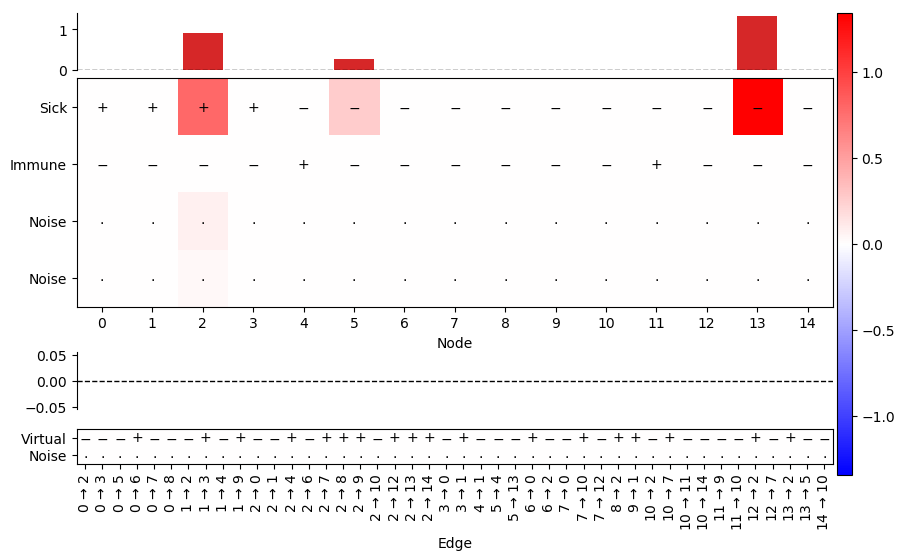

In [23]:
fig = plt.figure(figsize=(10, 6))
grid = plt.GridSpec(5, 2, height_ratios=[1, 4, .5, 1, 1], width_ratios=[50, 1], hspace=.1, wspace=.01)

vmax=max(
    batch.node_features.grad.abs().max(),
    batch.edge_features.grad.abs().max(),
    1e-16
)

ax = fig.add_subplot(grid[0,0])
ax.bar(torch.arange(graph_in.num_nodes), batch.node_features.grad.clamp(min=0).sum(dim=1), color='C3')
ax.set_xticks([])
ax.tick_params(axis='both', which='both', bottom=False, labelbottom=False)
ax.axhline(0, color='k', linestyle='--', linewidth=1.)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)

ax = fig.add_subplot(grid[1,0], sharex=ax)
im = ax.imshow(batch.node_features.grad.t(), cmap='bwr', vmin=-vmax, vmax=vmax, aspect='auto')
ax.set_xticks(torch.arange(graph_in.num_nodes))
ax.set_xlim(-.5, graph_in.num_nodes -.5)
ax.set_yticks(torch.arange(4))
ax.set_ylim(4 -.5, -.5)
ax.set_yticklabels(['Sick', 'Immune', 'Noise', 'Noise'])
ax.set_xlabel('Node')
for (j,i),label in np.ndenumerate(batch.node_features.detach().t().numpy()):
    ax.text(i,j, label_txt(label),ha='center',va='center')

ax = fig.add_subplot(grid[3,0])
ax.bar(torch.arange(graph_in.num_edges), batch.edge_features.grad.clamp(min=0).sum(dim=1), color='C3')
ax.set_xticks([])
ax.tick_params(axis='both', which='both', bottom=False, labelbottom=False)
ax.axhline(0, color='k', linestyle='--', linewidth=1.)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)

ax = fig.add_subplot(grid[4, 0], sharex=ax)
im = ax.imshow(batch.edge_features.grad.t(), cmap='bwr', vmin=-vmax, vmax=vmax)
ax.set_xticks(torch.arange(graph_in.num_edges))
ax.set_xlim(-.5, graph_in.num_edges -.5)
ax.set_xticklabels([f'${s}\\ \\to\\ {r}$' for s, r in zip(graph_in.senders, graph_in.receivers)], rotation=90)
ax.set_yticks(torch.arange(2))
ax.set_ylim(2 -.5, -.5)
ax.set_yticklabels(['Virtual', 'Noise'])
ax.set_xlabel('Edge');
for (j,i),label in np.ndenumerate(batch.edge_features.t().detach().numpy()):
    ax.text(i,j, label_txt(label),ha='center',va='center')

ax = fig.add_subplot(grid[:, 1])
fig.colorbar(mappable=im, cax=ax);

fig.tight_layout(pad=0)
display(fig)
fig.savefig(f'biggraph-node-{N}-gbp-nodesedges.png', dpi=300, pad_inches=0)
plt.close(fig)

### GBP: Explain node 4 that was immune

In [24]:
batch = tg.GraphBatch.collate([graph_in]).requires_grad_()
batch.node_features.register_hook(lambda grad: grad.clamp(min=0))
batch.edge_features.register_hook(lambda grad: grad.clamp(min=0))
graph_out = net(batch)[0]

N = 4
node_relevance = torch.zeros_like(graph_out.node_features)
node_relevance[N] = 1

batch.zero_grad_()
graph_out.node_features.backward(node_relevance)
title=f'Guided backpropagation for node {N}'

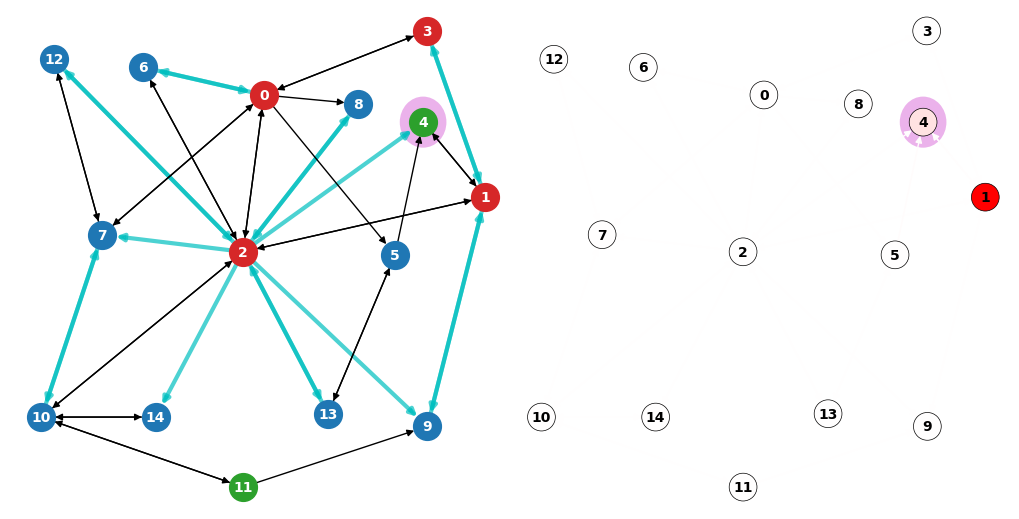

In [25]:
fig = plt.figure(figsize=(10, 5))

ax = plt.subplot2grid((1,2), loc=(0,0), fig=fig)
ax.add_patch(patches.Circle(layout[N], radius=.07, color='m', fill=True, alpha=.3, linewidth=0))
node_ids = {i: str(i) for i in range(graph_in.num_nodes)}
nx.draw_networkx_nodes(graph_in.to_networkx(), nodelist=infected, node_size=node_size, node_color='C3', pos=layout, ax=ax)
nx.draw_networkx_nodes(graph_in.to_networkx(), nodelist=immune,   node_size=node_size, node_color='C2', pos=layout, ax=ax)
nx.draw_networkx_nodes(graph_in.to_networkx(), nodelist=others,   node_size=node_size, node_color='C0', pos=layout, ax=ax)
nx.draw_networkx_edges(graph_in.to_networkx(), edgelist=virtual,    node_size=node_size, edge_color='c',  pos=layout, ax=ax, width=3., alpha=.7)
nx.draw_networkx_edges(graph_in.to_networkx(), edgelist=nonvirtual, node_size=node_size, edge_color='k',  pos=layout, ax=ax)
nx.draw_networkx_labels(graph_in.to_networkx(), pos=layout, labels=node_ids, ax=ax, font_size=font_size, font_weight='bold', font_color='white')
ax.tick_params(axis='both', which='both', bottom=False, labelbottom=False, left=False, labelleft=False)
ax.tick_params(axis='both', which='both', bottom=False, labelbottom=False, left=False, labelleft=False)
ax.set_ylim(-.71, .66)
ax.set_xlim(-.8, .70)
ax.axis('off')

ax = plt.subplot2grid((1,2), loc=(0,1), fig=fig)
ax.add_patch(patches.Circle(layout[N], radius=.07, color='m', fill=True, alpha=.3, linewidth=0))
vmax=max(batch.node_features.grad.sum(dim=1).abs().max(),batch.edge_features.grad.sum(dim=1).abs().max(),1e-16)
nx.draw_networkx_nodes(graph_in.to_networkx(), node_size=node_size, node_color=batch.node_features.grad.sum(dim=1), cmap='bwr',vmin=-vmax, vmax=vmax, pos=layout, ax=ax, linewidths=.5, edgecolors='k')
nx.draw_networkx_edges(graph_in.to_networkx(), node_size=node_size, edge_color=batch.edge_features.grad.sum(dim=1), edge_cmap=cm.get_cmap('bwr'),edge_vmin=-vmax, edge_vmax=vmax, pos=layout, ax=ax)
nx.draw_networkx_labels(graph_in.to_networkx(), pos=layout, labels=node_ids, ax=ax, font_size=font_size, font_weight='bold', font_color='k')
ax.tick_params(axis='both', which='both', bottom=False, labelbottom=False, left=False, labelleft=False)
ax.set_ylim(-.71, .66)
ax.set_xlim(-.8, .70)
ax.axis('off')

fig.tight_layout(pad=0)
display(fig)
fig.savefig(f'biggraph-node-{N}-gbp.png', dpi=300, pad_inches=0)
plt.close(fig)

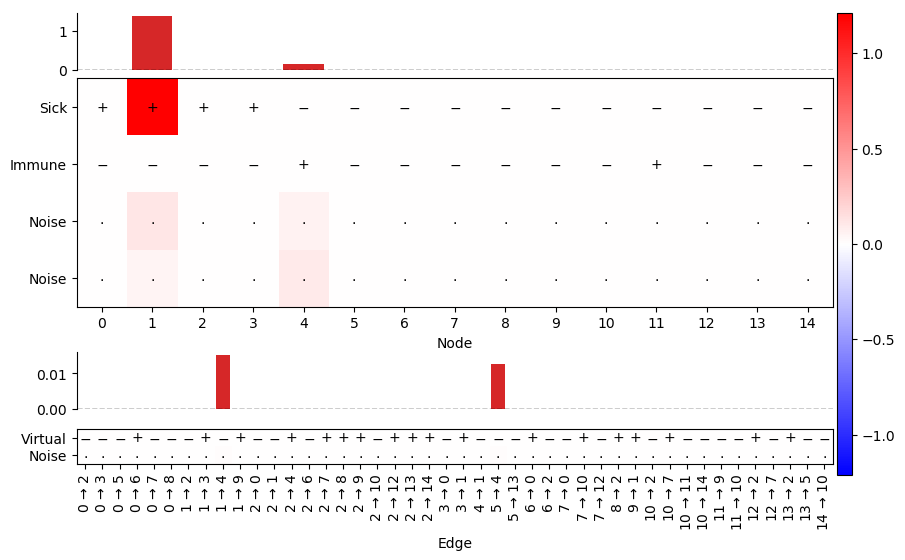

In [26]:
fig = plt.figure(figsize=(10, 6))
grid = plt.GridSpec(5, 2, height_ratios=[1, 4, .5, 1, 1], width_ratios=[50, 1], hspace=.1, wspace=.01)

vmax=max(
    batch.node_features.grad.abs().max(),
    batch.edge_features.grad.abs().max(),
    1e-16
)

ax = fig.add_subplot(grid[0,0])
ax.bar(torch.arange(graph_in.num_nodes), batch.node_features.grad.clamp(min=0).sum(dim=1), color='C3')
ax.set_xticks([])
ax.tick_params(axis='both', which='both', bottom=False, labelbottom=False)
ax.axhline(0, color='k', linestyle='--', linewidth=1.)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)

ax = fig.add_subplot(grid[1,0], sharex=ax)
im = ax.imshow(batch.node_features.grad.t(), cmap='bwr', vmin=-vmax, vmax=vmax, aspect='auto')
ax.set_xticks(torch.arange(graph_in.num_nodes))
ax.set_xlim(-.5, graph_in.num_nodes -.5)
ax.set_yticks(torch.arange(4))
ax.set_ylim(4 -.5, -.5)
ax.set_yticklabels(['Sick', 'Immune', 'Noise', 'Noise'])
ax.set_xlabel('Node')
for (j,i),label in np.ndenumerate(batch.node_features.detach().t().numpy()):
    ax.text(i,j, label_txt(label),ha='center',va='center')

ax = fig.add_subplot(grid[3,0])
ax.bar(torch.arange(graph_in.num_edges), batch.edge_features.grad.clamp(min=0).sum(dim=1), color='C3')
ax.set_xticks([])
ax.tick_params(axis='both', which='both', bottom=False, labelbottom=False)
ax.axhline(0, color='k', linestyle='--', linewidth=1.)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)

ax = fig.add_subplot(grid[4, 0], sharex=ax)
im = ax.imshow(batch.edge_features.grad.t(), cmap='bwr', vmin=-vmax, vmax=vmax)
ax.set_xticks(torch.arange(graph_in.num_edges))
ax.set_xlim(-.5, graph_in.num_edges -.5)
ax.set_xticklabels([f'${s}\\ \\to\\ {r}$' for s, r in zip(graph_in.senders, graph_in.receivers)], rotation=90)
ax.set_yticks(torch.arange(2))
ax.set_ylim(2 -.5, -.5)
ax.set_yticklabels(['Virtual', 'Noise'])
ax.set_xlabel('Edge');
for (j,i),label in np.ndenumerate(batch.edge_features.t().detach().numpy()):
    ax.text(i,j, label_txt(label),ha='center',va='center')

ax = fig.add_subplot(grid[:, 1])
fig.colorbar(mappable=im, cax=ax);

fig.tight_layout(pad=0)
display(fig)
fig.savefig(f'biggraph-node-{N}-gbp-nodesedges.png', dpi=300, pad_inches=0)
plt.close(fig)

## LRP

In [27]:
class InfectionGNRelevance(InfectionGN):
    def __init__(self, aggregation, bias):
        super(InfectionGN, self).__init__()
        self.encoder = torch.nn.Sequential(OrderedDict({
            'edge': relevance.EdgeLinearRelevance(4, edge_features=2, bias=bias),
            'edge_relu': relevance.EdgeReLURelevance(),
            'node': relevance.NodeLinearRelevance(8, node_features=4, bias=bias),
            'node_relu': relevance.NodeReLURelevance(),
        }))
        self.hidden = torch.nn.Sequential(OrderedDict({
            'edge': relevance.EdgeLinearRelevance(8, edge_features=4, sender_features=8, bias=bias),
            'edge_relu': relevance.EdgeReLURelevance(),
            'node': relevance.NodeLinearRelevance(8, node_features=8, incoming_features=8, aggregation=aggregation, bias=bias),
            'node_relu': relevance.NodeReLURelevance()
        }))
        self.readout_nodes = relevance.NodeLinearRelevance(1, node_features=8, bias=True)
        self.readout_globals = relevance.GlobalLinearRelevance(1, node_features=8, aggregation='sum', bias=bias)

net = InfectionGNRelevance(*model.args, **model.kwargs)
net.load_state_dict(torch.load(model.state_dict, map_location='cpu'))

### LRP: Explain node 10 that was healty and is now infected
- The major contribution to `10` being infected is that `2` is sick and not immune
- The fact that `2->10` is not virtual is also a contribution
- Node `7` being healthy and connected via a virtual edge brings a negative contribution instead

LRP explains signal, not variation

In [28]:
batch = tg.GraphBatch.collate([graph_in]).requires_grad_()
graph_out = net(batch)[0]

N = 10
node_relevance = torch.zeros_like(graph_out.node_features)
node_relevance[N] = graph_out.node_features[N]

batch.zero_grad_()
graph_out.node_features.backward(node_relevance)

title = f'Relevance for node {N} (initial {node_relevance[N].item():.3f})'

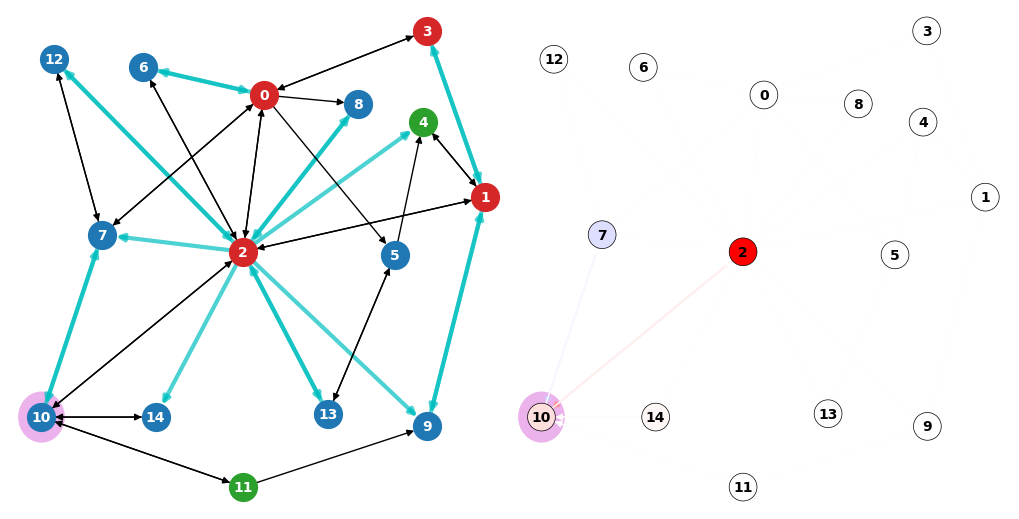

In [29]:
fig = plt.figure(figsize=(10, 5))

ax = plt.subplot2grid((1,2), loc=(0,0), fig=fig)
ax.add_patch(patches.Circle(layout[N], radius=.07, color='m', fill=True, alpha=.3, linewidth=0))
node_ids = {i: str(i) for i in range(graph_in.num_nodes)}
nx.draw_networkx_nodes(graph_in.to_networkx(), nodelist=infected, node_size=node_size, node_color='C3', pos=layout, ax=ax)
nx.draw_networkx_nodes(graph_in.to_networkx(), nodelist=immune,   node_size=node_size, node_color='C2', pos=layout, ax=ax)
nx.draw_networkx_nodes(graph_in.to_networkx(), nodelist=others,   node_size=node_size, node_color='C0', pos=layout, ax=ax)
nx.draw_networkx_edges(graph_in.to_networkx(), edgelist=virtual,    node_size=node_size, edge_color='c',  pos=layout, ax=ax, width=3., alpha=.7)
nx.draw_networkx_edges(graph_in.to_networkx(), edgelist=nonvirtual, node_size=node_size, edge_color='k',  pos=layout, ax=ax)
nx.draw_networkx_labels(graph_in.to_networkx(), pos=layout, labels=node_ids, ax=ax, font_size=font_size, font_weight='bold', font_color='white')
ax.tick_params(axis='both', which='both', bottom=False, labelbottom=False, left=False, labelleft=False)
ax.tick_params(axis='both', which='both', bottom=False, labelbottom=False, left=False, labelleft=False)
ax.set_ylim(-.71, .66)
ax.set_xlim(-.8, .70)
ax.axis('off')

ax = plt.subplot2grid((1,2), loc=(0,1), fig=fig)
ax.add_patch(patches.Circle(layout[N], radius=.07, color='m', fill=True, alpha=.3, linewidth=0))
vmax=max(batch.node_features.grad.sum(dim=1).abs().max(),batch.edge_features.grad.sum(dim=1).abs().max(),1e-16)
nx.draw_networkx_nodes(graph_in.to_networkx(), node_size=node_size, node_color=batch.node_features.grad.sum(dim=1), cmap='bwr',vmin=-vmax, vmax=vmax, pos=layout, ax=ax, linewidths=.5, edgecolors='k')
nx.draw_networkx_edges(graph_in.to_networkx(), node_size=node_size, edge_color=batch.edge_features.grad.sum(dim=1), edge_cmap=cm.get_cmap('bwr'),edge_vmin=-vmax, edge_vmax=vmax, pos=layout, ax=ax)
nx.draw_networkx_labels(graph_in.to_networkx(), pos=layout, labels=node_ids, ax=ax, font_size=font_size, font_weight='bold', font_color='k')
ax.tick_params(axis='both', which='both', bottom=False, labelbottom=False, left=False, labelleft=False)
ax.set_ylim(-.71, .66)
ax.set_xlim(-.8, .70)
ax.axis('off')

fig.tight_layout(pad=0)
display(fig)
fig.savefig(f'biggraph-node-{N}-lrp.png', dpi=300, pad_inches=0)
plt.close(fig)

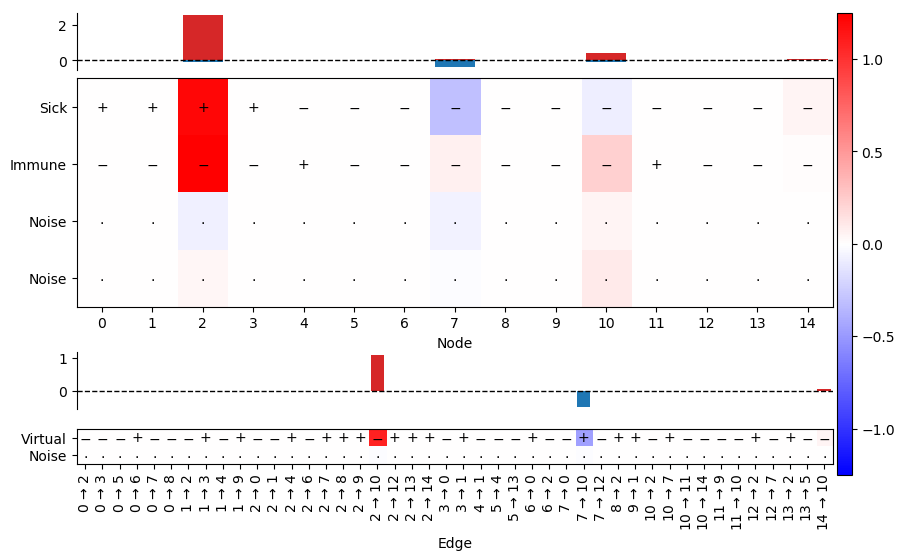

In [30]:
fig = plt.figure(figsize=(10, 6))
grid = plt.GridSpec(5, 2, height_ratios=[1, 4, .5, 1, 1], width_ratios=[50, 1], hspace=.1, wspace=.01)

vmax=max(
    batch.node_features.grad.abs().max(),
    batch.edge_features.grad.abs().max(),
    1e-16
)

ax = fig.add_subplot(grid[0,0])
ax.bar(torch.arange(graph_in.num_nodes), batch.node_features.grad.clamp(min=0).sum(dim=1), color='C3')
ax.bar(torch.arange(graph_in.num_nodes), batch.node_features.grad.clamp(max=0).sum(dim=1), color='C0')
ax.set_xticks([])
ax.tick_params(axis='both', which='both', bottom=False, labelbottom=False)
ax.axhline(0, color='k', linestyle='--', linewidth=1.)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)

ax = fig.add_subplot(grid[1,0], sharex=ax)
im = ax.imshow(batch.node_features.grad.t(), cmap='bwr', vmin=-vmax, vmax=vmax, aspect='auto')
ax.set_xticks(torch.arange(graph_in.num_nodes))
ax.set_xlim(-.5, graph_in.num_nodes -.5)
ax.set_yticks(torch.arange(4))
ax.set_ylim(4 -.5, -.5)
ax.set_yticklabels(['Sick', 'Immune', 'Noise', 'Noise'])
ax.set_xlabel('Node')
for (j,i),label in np.ndenumerate(batch.node_features.detach().t().numpy()):
    ax.text(i,j, label_txt(label),ha='center',va='center')

ax = fig.add_subplot(grid[3,0])
ax.bar(torch.arange(graph_in.num_edges), batch.edge_features.grad.clamp(min=0).sum(dim=1), color='C3')
ax.bar(torch.arange(graph_in.num_edges), batch.edge_features.grad.clamp(max=0).sum(dim=1), color='C0')
ax.set_xticks([])
ax.tick_params(axis='both', which='both', bottom=False, labelbottom=False)
ax.axhline(0, color='k', linestyle='--', linewidth=1.)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)

ax = fig.add_subplot(grid[4, 0], sharex=ax)
im = ax.imshow(batch.edge_features.grad.t(), cmap='bwr', vmin=-vmax, vmax=vmax)
ax.set_xticks(torch.arange(graph_in.num_edges))
ax.set_xlim(-.5, graph_in.num_edges -.5)
ax.set_xticklabels([f'${s}\\ \\to\\ {r}$' for s, r in zip(graph_in.senders, graph_in.receivers)], rotation=90)
ax.set_yticks(torch.arange(2))
ax.set_ylim(2 -.5, -.5)
ax.set_yticklabels(['Virtual', 'Noise'])
ax.set_xlabel('Edge');
for (j,i),label in np.ndenumerate(batch.edge_features.t().detach().numpy()):
    ax.text(i,j, label_txt(label),ha='center',va='center')

ax = fig.add_subplot(grid[:, 1])
fig.colorbar(mappable=im, cax=ax);

fig.tight_layout(pad=0)
display(fig)
fig.savefig(f'biggraph-node-{N}-lrp-nodesedges.png', dpi=300, pad_inches=0)
plt.close(fig)

### LRP: Explain node 13 that was healty and still is

- Initial relevance is negative
- The fact that `13` is initially healthy is a good start for its negative relevance
- The fact that its neighbor `5` is initially healthy also brings a contribution to the negative relevance
- A pull towards positive comes from node `2` which is sick
- But is counteracted with negative relevance from the fact that the edge `2->13` is virtual

In [31]:
batch = tg.GraphBatch.collate([graph_in]).requires_grad_()
graph_out = net(batch)[0]

N = 13
node_relevance = torch.zeros_like(graph_out.node_features)
node_relevance[N] = graph_out.node_features[N]

batch.zero_grad_()
graph_out.node_features.backward(node_relevance)
title = f'Relevance for node {N} (initial {node_relevance[N].item():.3f})'

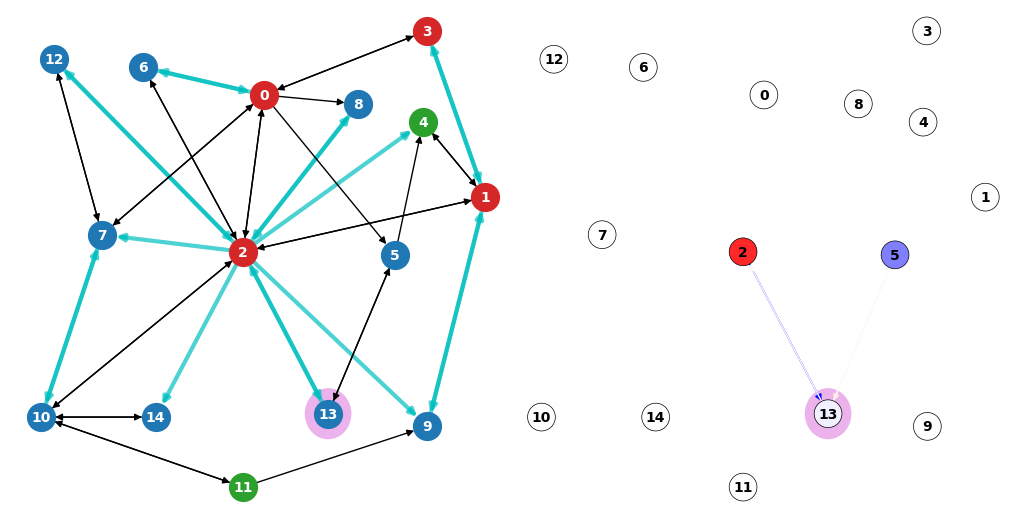

In [32]:
fig = plt.figure(figsize=(10, 5))

ax = plt.subplot2grid((1,2), loc=(0,0), fig=fig)
ax.add_patch(patches.Circle(layout[N], radius=.07, color='m', fill=True, alpha=.3, linewidth=0))
node_ids = {i: str(i) for i in range(graph_in.num_nodes)}
nx.draw_networkx_nodes(graph_in.to_networkx(), nodelist=infected, node_size=node_size, node_color='C3', pos=layout, ax=ax)
nx.draw_networkx_nodes(graph_in.to_networkx(), nodelist=immune,   node_size=node_size, node_color='C2', pos=layout, ax=ax)
nx.draw_networkx_nodes(graph_in.to_networkx(), nodelist=others,   node_size=node_size, node_color='C0', pos=layout, ax=ax)
nx.draw_networkx_edges(graph_in.to_networkx(), edgelist=virtual,    node_size=node_size, edge_color='c',  pos=layout, ax=ax, width=3., alpha=.7)
nx.draw_networkx_edges(graph_in.to_networkx(), edgelist=nonvirtual, node_size=node_size, edge_color='k',  pos=layout, ax=ax)
nx.draw_networkx_labels(graph_in.to_networkx(), pos=layout, labels=node_ids, ax=ax, font_size=font_size, font_weight='bold', font_color='white')
ax.tick_params(axis='both', which='both', bottom=False, labelbottom=False, left=False, labelleft=False)
ax.tick_params(axis='both', which='both', bottom=False, labelbottom=False, left=False, labelleft=False)
ax.set_ylim(-.71, .66)
ax.set_xlim(-.8, .70)
ax.axis('off')

ax = plt.subplot2grid((1,2), loc=(0,1), fig=fig)
ax.add_patch(patches.Circle(layout[N], radius=.07, color='m', fill=True, alpha=.3, linewidth=0))
vmax=max(batch.node_features.grad.sum(dim=1).abs().max(),batch.edge_features.grad.sum(dim=1).abs().max(),1e-16)
nx.draw_networkx_nodes(graph_in.to_networkx(), node_size=node_size, node_color=batch.node_features.grad.sum(dim=1), cmap='bwr',vmin=-vmax, vmax=vmax, pos=layout, ax=ax, linewidths=.5, edgecolors='k')
nx.draw_networkx_edges(graph_in.to_networkx(), node_size=node_size, edge_color=batch.edge_features.grad.sum(dim=1), edge_cmap=cm.get_cmap('bwr'),edge_vmin=-vmax, edge_vmax=vmax, pos=layout, ax=ax)
nx.draw_networkx_labels(graph_in.to_networkx(), pos=layout, labels=node_ids, ax=ax, font_size=font_size, font_weight='bold', font_color='k')
ax.tick_params(axis='both', which='both', bottom=False, labelbottom=False, left=False, labelleft=False)
ax.set_ylim(-.71, .66)
ax.set_xlim(-.8, .70)
ax.axis('off')

fig.tight_layout(pad=0)
display(fig)
fig.savefig(f'biggraph-node-{N}-lrp.png', dpi=300, pad_inches=0)
plt.close(fig)

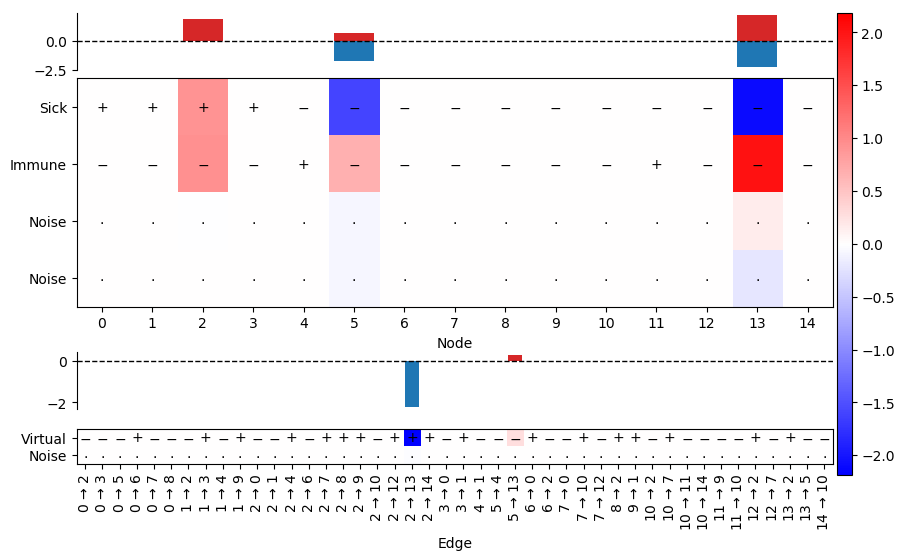

In [33]:
fig = plt.figure(figsize=(10, 6))
grid = plt.GridSpec(5, 2, height_ratios=[1, 4, .5, 1, 1], width_ratios=[50, 1], hspace=.1, wspace=.01)

vmax=max(
    batch.node_features.grad.abs().max(),
    batch.edge_features.grad.abs().max(),
    1e-16
)

ax = fig.add_subplot(grid[0,0])
ax.bar(torch.arange(graph_in.num_nodes), batch.node_features.grad.clamp(min=0).sum(dim=1), color='C3')
ax.bar(torch.arange(graph_in.num_nodes), batch.node_features.grad.clamp(max=0).sum(dim=1), color='C0')
ax.set_xticks([])
ax.tick_params(axis='both', which='both', bottom=False, labelbottom=False)
ax.axhline(0, color='k', linestyle='--', linewidth=1.)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)

ax = fig.add_subplot(grid[1,0], sharex=ax)
im = ax.imshow(batch.node_features.grad.t(), cmap='bwr', vmin=-vmax, vmax=vmax, aspect='auto')
ax.set_xticks(torch.arange(graph_in.num_nodes))
ax.set_xlim(-.5, graph_in.num_nodes -.5)
ax.set_yticks(torch.arange(4))
ax.set_ylim(4 -.5, -.5)
ax.set_yticklabels(['Sick', 'Immune', 'Noise', 'Noise'])
ax.set_xlabel('Node')
for (j,i),label in np.ndenumerate(batch.node_features.detach().t().numpy()):
    ax.text(i,j, label_txt(label),ha='center',va='center')

ax = fig.add_subplot(grid[3,0])
ax.bar(torch.arange(graph_in.num_edges), batch.edge_features.grad.clamp(min=0).sum(dim=1), color='C3')
ax.bar(torch.arange(graph_in.num_edges), batch.edge_features.grad.clamp(max=0).sum(dim=1), color='C0')
ax.set_xticks([])
ax.tick_params(axis='both', which='both', bottom=False, labelbottom=False)
ax.axhline(0, color='k', linestyle='--', linewidth=1.)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)

ax = fig.add_subplot(grid[4, 0], sharex=ax)
im = ax.imshow(batch.edge_features.grad.t(), cmap='bwr', vmin=-vmax, vmax=vmax)
ax.set_xticks(torch.arange(graph_in.num_edges))
ax.set_xlim(-.5, graph_in.num_edges -.5)
ax.set_xticklabels([f'${s}\\ \\to\\ {r}$' for s, r in zip(graph_in.senders, graph_in.receivers)], rotation=90)
ax.set_yticks(torch.arange(2))
ax.set_ylim(2 -.5, -.5)
ax.set_yticklabels(['Virtual', 'Noise'])
ax.set_xlabel('Edge');
for (j,i),label in np.ndenumerate(batch.edge_features.t().detach().numpy()):
    ax.text(i,j, label_txt(label),ha='center',va='center')

ax = fig.add_subplot(grid[:, 1])
fig.colorbar(mappable=im, cax=ax);

fig.tight_layout(pad=0)
display(fig)
fig.savefig(f'biggraph-node-{N}-lrp-nodesedges.png', dpi=300, pad_inches=0)
plt.close(fig)

### LRP: Explain node 4 that was immune

- Initial relevance is negative
- Most of the negative relevance is placed on the immune feture of node 4 itself
- The fact that `2` is sick brings some positibe relevance, but not large enough

In [34]:
batch = tg.GraphBatch.collate([graph_in]).requires_grad_()
graph_out = net(batch)[0]

N = 4
node_relevance = torch.zeros_like(graph_out.node_features)
node_relevance[N] = graph_out.node_features[N]

batch.zero_grad_()
graph_out.node_features.backward(node_relevance)
title = f'Relevance for node {N} (initial {node_relevance[N].item():.3f})'

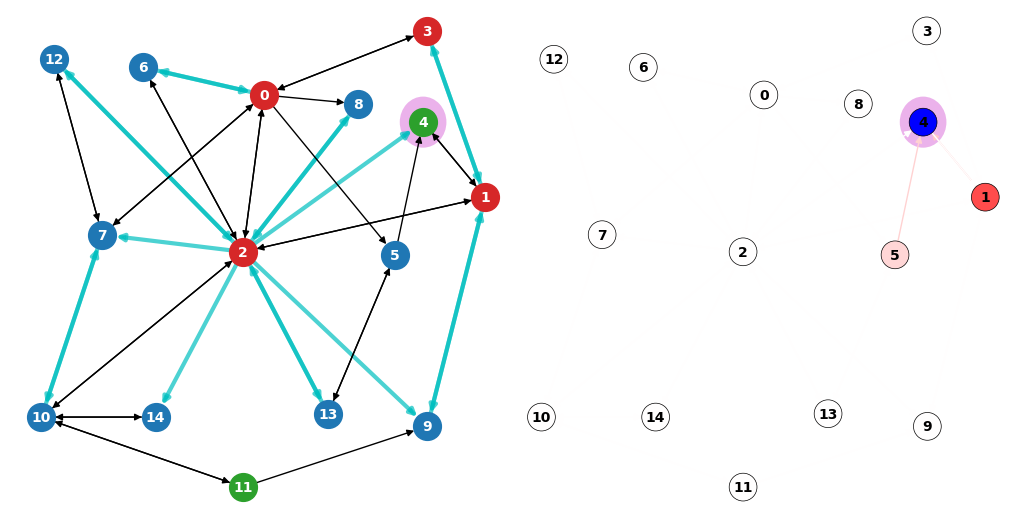

In [35]:
fig = plt.figure(figsize=(10, 5))

ax = plt.subplot2grid((1,2), loc=(0,0), fig=fig)
ax.add_patch(patches.Circle(layout[N], radius=.07, color='m', fill=True, alpha=.3, linewidth=0))
node_ids = {i: str(i) for i in range(graph_in.num_nodes)}
nx.draw_networkx_nodes(graph_in.to_networkx(), nodelist=infected, node_size=node_size, node_color='C3', pos=layout, ax=ax)
nx.draw_networkx_nodes(graph_in.to_networkx(), nodelist=immune,   node_size=node_size, node_color='C2', pos=layout, ax=ax)
nx.draw_networkx_nodes(graph_in.to_networkx(), nodelist=others,   node_size=node_size, node_color='C0', pos=layout, ax=ax)
nx.draw_networkx_edges(graph_in.to_networkx(), edgelist=virtual,    node_size=node_size, edge_color='c',  pos=layout, ax=ax, width=3., alpha=.7)
nx.draw_networkx_edges(graph_in.to_networkx(), edgelist=nonvirtual, node_size=node_size, edge_color='k',  pos=layout, ax=ax)
nx.draw_networkx_labels(graph_in.to_networkx(), pos=layout, labels=node_ids, ax=ax, font_size=font_size, font_weight='bold', font_color='white')
ax.tick_params(axis='both', which='both', bottom=False, labelbottom=False, left=False, labelleft=False)
ax.tick_params(axis='both', which='both', bottom=False, labelbottom=False, left=False, labelleft=False)
ax.set_ylim(-.71, .66)
ax.set_xlim(-.8, .70)
ax.axis('off')

ax = plt.subplot2grid((1,2), loc=(0,1), fig=fig)
ax.add_patch(patches.Circle(layout[N], radius=.07, color='m', fill=True, alpha=.3, linewidth=0))
vmax=max(batch.node_features.grad.sum(dim=1).abs().max(),batch.edge_features.grad.sum(dim=1).abs().max(),1e-16)
nx.draw_networkx_nodes(graph_in.to_networkx(), node_size=node_size, node_color=batch.node_features.grad.sum(dim=1), cmap='bwr',vmin=-vmax, vmax=vmax, pos=layout, ax=ax, linewidths=.5, edgecolors='k')
nx.draw_networkx_edges(graph_in.to_networkx(), node_size=node_size, edge_color=batch.edge_features.grad.sum(dim=1), edge_cmap=cm.get_cmap('bwr'),edge_vmin=-vmax, edge_vmax=vmax, pos=layout, ax=ax)
nx.draw_networkx_labels(graph_in.to_networkx(), pos=layout, labels=node_ids, ax=ax, font_size=font_size, font_weight='bold', font_color='k')
ax.tick_params(axis='both', which='both', bottom=False, labelbottom=False, left=False, labelleft=False)
ax.set_ylim(-.71, .66)
ax.set_xlim(-.8, .70)
ax.axis('off')

fig.tight_layout(pad=0)
display(fig)
fig.savefig(f'biggraph-node-{N}-lrp.png', dpi=300, pad_inches=0)
plt.close(fig)

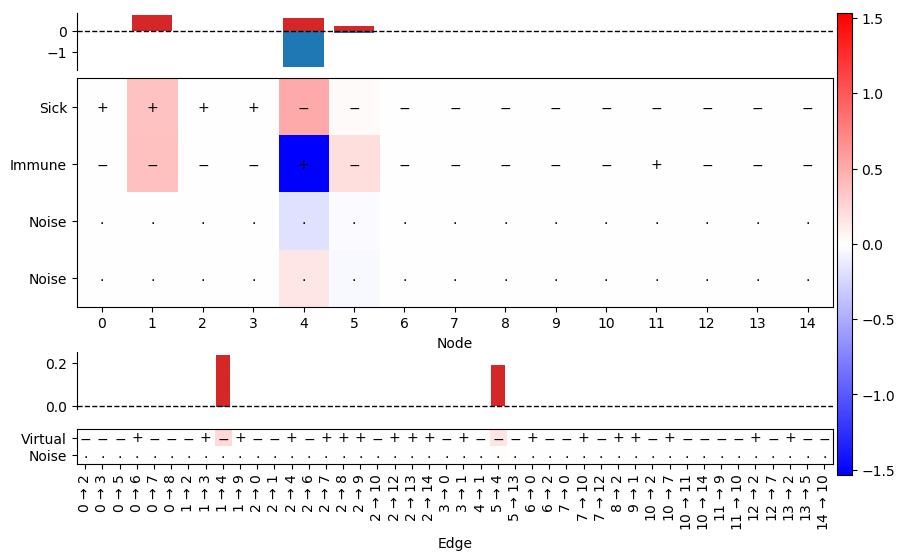

In [36]:
fig = plt.figure(figsize=(10, 6))
grid = plt.GridSpec(5, 2, height_ratios=[1, 4, .5, 1, 1], width_ratios=[50, 1], hspace=.1, wspace=.01)

vmax=max(
    batch.node_features.grad.abs().max(),
    batch.edge_features.grad.abs().max(),
    1e-16
)

ax = fig.add_subplot(grid[0,0])
ax.bar(torch.arange(graph_in.num_nodes), batch.node_features.grad.clamp(min=0).sum(dim=1), color='C3')
ax.bar(torch.arange(graph_in.num_nodes), batch.node_features.grad.clamp(max=0).sum(dim=1), color='C0')
ax.set_xticks([])
ax.tick_params(axis='both', which='both', bottom=False, labelbottom=False)
ax.axhline(0, color='k', linestyle='--', linewidth=1.)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)

ax = fig.add_subplot(grid[1,0], sharex=ax)
im = ax.imshow(batch.node_features.grad.t(), cmap='bwr', vmin=-vmax, vmax=vmax, aspect='auto')
ax.set_xticks(torch.arange(graph_in.num_nodes))
ax.set_xlim(-.5, graph_in.num_nodes -.5)
ax.set_yticks(torch.arange(4))
ax.set_ylim(4 -.5, -.5)
ax.set_yticklabels(['Sick', 'Immune', 'Noise', 'Noise'])
ax.set_xlabel('Node')
for (j,i),label in np.ndenumerate(batch.node_features.detach().t().numpy()):
    ax.text(i,j, label_txt(label),ha='center',va='center')

ax = fig.add_subplot(grid[3,0])
ax.bar(torch.arange(graph_in.num_edges), batch.edge_features.grad.clamp(min=0).sum(dim=1), color='C3')
ax.bar(torch.arange(graph_in.num_edges), batch.edge_features.grad.clamp(max=0).sum(dim=1), color='C0')
ax.set_xticks([])
ax.tick_params(axis='both', which='both', bottom=False, labelbottom=False)
ax.axhline(0, color='k', linestyle='--', linewidth=1.)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)

ax = fig.add_subplot(grid[4, 0], sharex=ax)
im = ax.imshow(batch.edge_features.grad.t(), cmap='bwr', vmin=-vmax, vmax=vmax)
ax.set_xticks(torch.arange(graph_in.num_edges))
ax.set_xlim(-.5, graph_in.num_edges -.5)
ax.set_xticklabels([f'${s}\\ \\to\\ {r}$' for s, r in zip(graph_in.senders, graph_in.receivers)], rotation=90)
ax.set_yticks(torch.arange(2))
ax.set_ylim(2 -.5, -.5)
ax.set_yticklabels(['Virtual', 'Noise'])
ax.set_xlabel('Edge');
for (j,i),label in np.ndenumerate(batch.edge_features.t().detach().numpy()):
    ax.text(i,j, label_txt(label),ha='center',va='center')

ax = fig.add_subplot(grid[:, 1])
fig.colorbar(mappable=im, cax=ax);

fig.tight_layout(pad=0)
display(fig)
fig.savefig(f'biggraph-node-{N}-lrp-nodesedges.png', dpi=300, pad_inches=0)
plt.close(fig)